In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_performance import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


In [3]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

# Selecting the simu data

In [4]:
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20181129'
data_snippets_dir = 'ver4_machine_learning_flight_classification'

# os.makedirs(data_snippets_dir, exist_ok=True)

In [5]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

## Columns

In [6]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names.txt


In [7]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names__special.txt


In [8]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [9]:
simu_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=\
        [('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu')] + \
        rfecv_selector_on_extra_trees__column_names
)
print_columns_dict(simu_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- max_size_clu_height
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- max_size_clu_height
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_orig_x_y
	- count_nonzero

spb_processing_v4_simu_flatmap.event_proc2_x_y_clusters
	- max_peak_clu_width

spb_processing_v4_simu_flatmap.event_proc3_x_y_clusters
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_proc2_gtu_y_clusters
	- max_size_clu_height

spb_processing_v4_simu_flatmap.event_bg_x_y
	- count_nonzero

spb_p

## Constructing the query

In [10]:
source_data_type_num_classification = 3001
source_data_type_num_filter = 1001

In [11]:
current_columns_for_analysis_dict = simu_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_format = \
'''
AND {does_exist} EXISTS (
    SELECT e2.event_id FROM spb_processing_v4_simu_flatmap.event AS e2 
    WHERE 
        e2.source_data_type_num={source_data_type_num:d} 
        AND spb_processing_v4_simu_flatmap.event.source_file_acquisition=e2.source_file_acquisition 
        AND (
            (spb_processing_v4_simu_flatmap.event.gtu_in_packet <= e2.gtu_in_packet AND e2.gtu_in_packet - spb_processing_v4_simu_flatmap.event.gtu_in_packet < spb_processing_v4_simu_flatmap.event.num_gtu - 4) 
            OR 
            (e2.gtu_in_packet < spb_processing_v4_simu_flatmap.event.gtu_in_packet AND spb_processing_v4_simu_flatmap.event.gtu_in_packet - e2.gtu_in_packet < e2.num_gtu - 4)
        )
)
'''

simu_where_clauses_str = simu_where_clauses_format.format(does_exist='', source_data_type_num=source_data_type_num_filter)

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)


simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num_classification,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

print(simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_size_clu_width, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_height AS trg_x_y_clusters_max_size_clu_height, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_peak_clu_width AS trg_x_y_clusters_max_peak_clu_width, spb_processing_v4_simu_flatmap.eve

In [12]:
count_filtered_out_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num_classification,
    select_additional='COUNT(*)', 
    join_additional='',
    where_additional=simu_where_clauses_format.format(does_exist='NOT', source_data_type_num=source_data_type_num_filter),
    order_by=None, 
    offset=0, limit=350000,
    base_select='')

print(count_filtered_out_query)


    SELECT 
        
        COUNT(*)
     FROM spb_processing_v4_simu_flatmap.event
     
    WHERE
        source_data_type_num = 3001
        
AND NOT EXISTS (
    SELECT e2.event_id FROM spb_processing_v4_simu_flatmap.event AS e2 
    WHERE 
        e2.source_data_type_num=1001 
        AND spb_processing_v4_simu_flatmap.event.source_file_acquisition=e2.source_file_acquisition 
        AND (
            (spb_processing_v4_simu_flatmap.event.gtu_in_packet <= e2.gtu_in_packet AND e2.gtu_in_packet - spb_processing_v4_simu_flatmap.event.gtu_in_packet < spb_processing_v4_simu_flatmap.event.num_gtu - 4) 
            OR 
            (e2.gtu_in_packet < spb_processing_v4_simu_flatmap.event.gtu_in_packet AND spb_processing_v4_simu_flatmap.event.gtu_in_packet - e2.gtu_in_packet < e2.num_gtu - 4)
        )
)

    
    OFFSET 0 LIMIT 350000
    


## Selecting the data

In [13]:
simu_bgf1_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [14]:
simu_bgf1_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,138,...,0,35283,1,1.000000e+13,0.696797,4.65066,27000000.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,78,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
4,11499,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0


## Adding additional information

In [15]:
add_bin_column(simu_bgf1_df, 'num_frames_signals_ge_bg', 5);

In [16]:
simu_bgf1_df['is_visible'] = \
    (simu_bgf1_df['num_frames_signals_ge_bg'] >= 2) & (simu_bgf1_df['num_frames_signals_ge_bg'] <= 999) & \
    (32 <= simu_bgf1_df['gtu_in_packet']) & (simu_bgf1_df['gtu_in_packet'] <= 52)
# TODO 32 <= gtu_in_packet <= 52 range in not ideal

In [17]:
print("len(simu_df)                       ", len(simu_bgf1_df))
print("len(simu_df[simu_df['is_visible']])", len(simu_bgf1_df[simu_bgf1_df['is_visible']]))

len(simu_df)                        18919
len(simu_df[simu_df['is_visible']]) 13535


In [18]:
def shorted_simu2npy_pathname(x, remove_until_str='SPBDATA_processed/spb_simu/', simu2npy_pathname_col='simu2npy_pathname'):
    s = x[simu2npy_pathname_col]
    try:
        short_path = s[s.index(remove_until_str)+len(remove_until_str):]
    except ValueError:
        short_path = s
        
    return short_path


def simu2npy_signals_pathname(x, replaced_suffix='__info.txt', replacement_suffix='_mc_1__signals.npy', simu2npy_pathname_col='simu2npy_pathname'):
    s = x[simu2npy_pathname_col]
    if not s.endswith(replaced_suffix):
        raise RuntimeError('Unexpected contents of simu2npy_pathname')
    s_new = s[:-len(replaced_suffix)] + replacement_suffix
    return s_new


simu_bgf1_df['simu2npy_signals_pathname'] = simu_bgf1_df.apply(simu2npy_signals_pathname, axis=1)
simu_bgf1_df['simu2npy_signals_pathname_short'] = simu_bgf1_df.apply(lambda x: shorted_simu2npy_pathname(x, simu2npy_pathname_col='simu2npy_signals_pathname'), axis=1)

In [19]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

simu_bgf1_df, unclassified_simu_bgf1_df, track_simu_bgf1_df, noisy_simu_bgf1_df, \
simu_bgf1_signal_track_events_df, simu_bgf1_signal_noisy_events_df = \
    add_classification_columns(simu_bgf1_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path)

## Checking dataset of simu tracks

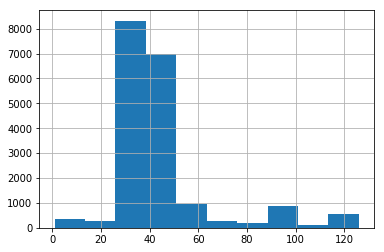

In [20]:
simu_bgf1_df['gtu_in_packet'].hist()
plt.show()

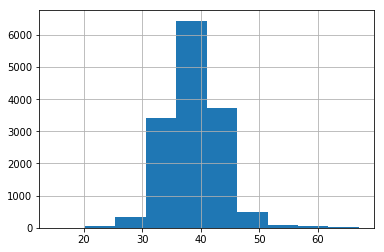

In [21]:
track_simu_bgf1_df['gtu_in_packet'].hist()
plt.show()

<big>Caution</big>
- There should not be too high gtu_in_packet

### Checking few non-track events

In [22]:
# 48941 should not be there !!!
48941 in track_simu_bgf1_df['event_id'].values

False

In [23]:
# 2112010 should not be there. PROBABLY - TOTO INVESTIGATE
2112010 in track_simu_bgf1_df['event_id'].values

False

In [24]:
for i,v in track_simu_bgf1_df[ track_simu_bgf1_df['event_id'] == 2112010 ].iterrows():
    for k,v in v.iteritems():
        print('{:<80} {}'.format(k,v))
    print('='*50)

In [25]:
2548363 in track_simu_bgf1_df['event_id'].values

True

In [26]:
event_2548363_df = track_simu_bgf1_df[ track_simu_bgf1_df['event_id'] == 2548363 ]

for i,r in event_2548363_df.iterrows():
    for k,v in r.iteritems():
        print('{:<80} {}'.format(k,v))
    print('='*50)

event_id                                                                         2548363
source_file_acquisition_full                                                     /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.41e+12/thousnd33E3/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n319_m128_Cinverse_flat_average_directions_4m_flipud.npy
source_file_trigger_full                                                         /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.41e+12/thousnd33E3/l1_trigger_kenji/trn_ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n319_m128_Cinverse_flat_average_directions_4m_flipud_ec_asc_bgf_0.50.root
source_file_acquisition                                                          posz_33000000.00/energy_1.41e+12/thousnd33E3/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n319_m128_Cinverse_flat_average_directions_4m_flipud.npy
source_file_t

In [27]:
event_2548363_df['simu2npy_signals_pathname_short']

16681    posz_33000000.00/energy_1.41e+12/thousnd33E3/s...
Name: simu2npy_signals_pathname_short, dtype: object

In [28]:
if len(event_2548363_df) > 0:
    for i,r in simu_bgf1_signal_track_events_df[
            simu_bgf1_signal_track_events_df['source_file_acquisition'] == event_2548363_df.iloc[0]['simu2npy_signals_pathname_short']
    ].iterrows():
        for k,v in r.iteritems():
            print('{:<80} {}'.format(k,v))
        print('='*50)

Unnamed: 0                                                                       11451
event_id                                                                         11452
source_file_acquisition                                                          posz_33000000.00/energy_1.41e+12/thousnd33E3/simu2npy/ev_0_mc_1__signals.npy
global_gtu                                                                       30
packet_id                                                                        0
gtu_in_packet                                                                    30
num_gtu                                                                          38
source_file_acquisition_full                                                     /home/spbproc/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.41e+12/thousnd33E3/simu2npy/ev_0_mc_1__signals.npy
num_frames                                                                       53
simu2npy_pathname                                 

In [71]:
simu_npy_2548363 = np.load(
    simu_bgf1_signal_track_events_df[
        simu_bgf1_signal_track_events_df['source_file_acquisition'] == event_2548363_df.iloc[0]['simu2npy_signals_pathname_short']
    ].iloc[0]['source_file_acquisition_full'])

In [72]:
print(len(simu_npy_2548363))

53


In [73]:
[np.max(a) for a in simu_npy_2548363]

[2,
 2,
 2,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0]

simu_npy_2548363[0:24]


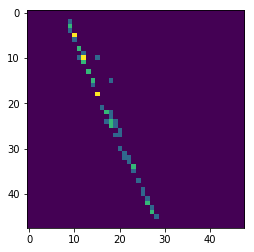

simu_npy_2548363[24:]


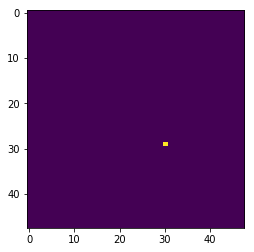

In [81]:
print('simu_npy_2548363[0:24]')
plt.close('all')
plt.imshow(np.max(simu_npy_2548363[0:24], axis=0))
plt.show()
print('simu_npy_2548363[24:]')
plt.close('all')
plt.imshow(np.max(simu_npy_2548363[24:], axis=0))
plt.show()

In [68]:
def _t_add_classification_columns(
        simu_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path, sep='\t', ret_simu_signal=True,
        class_column='cond_selection_simple', track_class='track', noise_class='noise', unclassified_class='unclassified', 
        column_in_simu_signal='source_file_acquisition', column_in_simu_df='simu2npy_signals_pathname_short',
        signals_pathname_func=simu2npy_signals_pathname, shorted_pathname_func=shorted_simu2npy_pathname,
        simu_event_start_offset=-4, simu_signal_event_start_offset=-4,
        simu_event_inject_gtu = 30, simu_signal_event_inject_gtu = 30,
        gtu_in_packet_column='gtu_in_packet', simu_num_gtu_column='num_gtu',
        simu_signal_num_frames_column='num_frames', simu_signal_num_gtu_column='num_gtu'
        ):
    # should be more universal

    #simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
    #simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
    #simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

    simu_signal_track_events_df = pd.read_csv(simu_signal_visible_tracks_table_path, sep='\t')
    simu_signal_noisy_events_df = pd.read_csv(simu_signal_noisy_events_table_path, sep='\t')

    #print('len(simu_signal_track_events_df) = ', len(simu_signal_track_events_df))
    #print('len(simu_signal_noisy_events_df) = ', len(simu_signal_noisy_events_df))

    extend_simu_signal_by_signals_pathname(simu_df, signals_pathname_func=signals_pathname_func, shorted_pathname_func=shorted_pathname_func)

    # simu_df[class_column] = unclassified_class
    # simu_df.loc[simu_df[column_in_simu_df].isin(simu_signal_track_events_df[column_in_simu_signal]), class_column] = track_class
    # simu_df.loc[simu_df[column_in_simu_df].isin(simu_signal_noisy_events_df[column_in_simu_signal]), class_column] = noise_class

    # inefficient slow solution

    simu_track_events_mask = simu_df[column_in_simu_df].isin(simu_signal_track_events_df[column_in_simu_signal])
    simu_noisy_events_mask = simu_df[column_in_simu_df].isin(simu_signal_noisy_events_df[column_in_simu_signal])

    for i, r in simu_df.iterrows():

        # if i % 100 == 0:
        #     print('{}/{}'.format(i, len(simu_df)))
        
        if r['event_id'] != 2548363:
            continue
        
        simu_first_gtu = r[gtu_in_packet_column] + simu_event_start_offset - simu_event_inject_gtu
        simu_last_gtu = simu_first_gtu + r[simu_num_gtu_column]
        r_pathname = r[column_in_simu_df]

        for dest_mask, simu_signal_df in [
            (simu_track_events_mask, simu_signal_track_events_df),
#             (simu_noisy_events_mask, simu_signal_noisy_events_df)
        ]:

            if not dest_mask[i]:
                continue

            simu_signal_subset = simu_signal_df[simu_signal_df[column_in_simu_signal] == r_pathname]

            if len(simu_signal_subset) <= 0:
                continue

            # print('len(simu_signal_subset)', len(simu_signal_subset))

            simu_signal_first_gtu = \
                simu_signal_subset[gtu_in_packet_column] + simu_signal_event_start_offset - simu_signal_event_inject_gtu
            simu_signal_last_gtu = \
                simu_signal_first_gtu + \
                np.min([
                    simu_signal_subset[simu_signal_num_frames_column].values,
                    simu_signal_subset[simu_signal_num_gtu_column].values], axis=0)


            print('simu_signal_last_gtu',simu_signal_last_gtu.tolist())
            print('simu_first_gtu', simu_first_gtu)
            print('(simu_signal_last_gtu >= simu_first_gtu)', (simu_signal_last_gtu >= simu_first_gtu).tolist())
            print('simu_signal_first_gtu', simu_signal_first_gtu.tolist())
            print('simu_last_gtu', simu_last_gtu)
            print('(simu_signal_first_gtu <= simu_last_gtu)', (simu_signal_first_gtu <= simu_last_gtu).tolist())

            
            
            num_simu_signal_events = np.count_nonzero(
                (simu_signal_last_gtu >= simu_first_gtu) & (simu_signal_first_gtu <= simu_last_gtu)
            )

            dest_mask[i] = num_simu_signal_events > 0
            

#     simu_df[class_column] = unclassified_class
#     simu_df.loc[simu_track_events_mask, class_column] = track_class
#     simu_df.loc[simu_noisy_events_mask, class_column] = noise_class

#     unclassified_simu_df = simu_df.query('{} == "{}"'.format(class_column, unclassified_class))
#     track_simu_df = simu_df.query('{} == "{}"'.format(class_column, track_class))
#     noisy_simu_df = simu_df.query('{} == "{}"'.format(class_column, noise_class))

#     if ret_simu_signal:
#         return simu_df, unclassified_simu_df, track_simu_df, noisy_simu_df, simu_signal_track_events_df, simu_signal_noisy_events_df
    
#     return simu_df, unclassified_simu_df, track_simu_df, noisy_simu_df


_t_add_classification_columns(simu_bgf1_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path)

simu_signal_last_gtu [34]
simu_first_gtu 24
(simu_signal_last_gtu >= simu_first_gtu) [True]
simu_signal_first_gtu [-4]
simu_last_gtu 39
(simu_signal_first_gtu <= simu_last_gtu) [True]


## Subsets

In [29]:
simu_bgf1_visible_tracks_mask = simu_bgf1_df['is_visible'] & (simu_bgf1_df['cond_selection_simple'] == 'track')

In [30]:
simu_bgf1_tracks_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'track']
simu_bgf1_unclassified_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'unclassified']
simu_bgf1_noise_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'noise']
simu_bgf1_visible_df = simu_bgf1_df[simu_bgf1_df['is_visible']]
simu_bgf1_visible_tracks_df = simu_bgf1_df[simu_bgf1_visible_tracks_mask]

In [31]:
cns = rfecv_selector_on_extra_trees__column_names

simu_bgf1_nonan_df = \
    simu_bgf1_df[
        simu_bgf1_df.isin(
            simu_bgf1_df[cns].dropna()).any(axis=1) ]

simu_bgf1_tracks_nonan_df = \
    simu_bgf1_tracks_df[
        simu_bgf1_tracks_df.isin(
            simu_bgf1_tracks_df[cns].dropna()).any(axis=1) ]

simu_bgf1_unclassified_nonan_df = \
    simu_bgf1_unclassified_df[
        simu_bgf1_unclassified_df.isin(
            simu_bgf1_unclassified_df[cns].dropna()).any(axis=1) ]

simu_bgf1_noise_nonan_df = \
    simu_bgf1_noise_df[
        simu_bgf1_noise_df.isin(
            simu_bgf1_noise_df[cns].dropna()).any(axis=1) ]

simu_bgf1_visible_tracks_nonan_df = \
    simu_bgf1_visible_tracks_df[
        simu_bgf1_visible_tracks_df.isin(
            simu_bgf1_visible_tracks_df[cns].dropna()).any(axis=1) ]


In [32]:
len(simu_bgf1_visible_tracks_df[rfecv_selector_on_extra_trees__column_names].dropna())

13368

In [33]:
print("len(simu_bgf1_df)               ", len(simu_bgf1_df))
print("len(simu_bgf1_tracks_df)        ", len(simu_bgf1_tracks_df))
print("len(simu_bgf1_unclassified_df)  ", len(simu_bgf1_unclassified_df))
print("len(simu_bgf1_noise_df)         ", len(simu_bgf1_noise_df))
print("len(simu_bgf1_visible_tracks_df)", len(simu_bgf1_visible_tracks_df))
print("len(simu_bgf1_visible_tracks_df) / len(simu_bgf1_df)", len(simu_bgf1_visible_tracks_df)/len(simu_bgf1_df))

len(simu_bgf1_df)                18919
len(simu_bgf1_tracks_df)         14599
len(simu_bgf1_unclassified_df)   3388
len(simu_bgf1_noise_df)          932
len(simu_bgf1_visible_tracks_df) 13385
len(simu_bgf1_visible_tracks_df) / len(simu_bgf1_df) 0.7074898250436069


In [34]:
print("len(simu_bgf1_nonan_df)               ", len(simu_bgf1_nonan_df))
print("len(simu_bgf1_tracks_nonan_df)        ", len(simu_bgf1_tracks_nonan_df))
print("len(simu_bgf1_unclassified_nonan_df)  ", len(simu_bgf1_unclassified_nonan_df))
print("len(simu_bgf1_noise_nonan_df)         ", len(simu_bgf1_noise_nonan_df))
print("len(simu_bgf1_visible_tracks_nonan_df)", len(simu_bgf1_visible_tracks_nonan_df))
print("len(simu_bgf1_visible_tracks_nonan_df) / len(simu_bgf1_nonan_df)", len(simu_bgf1_visible_tracks_nonan_df)/len(simu_bgf1_nonan_df))

len(simu_bgf1_nonan_df)                18871
len(simu_bgf1_tracks_nonan_df)         14570
len(simu_bgf1_unclassified_nonan_df)   3369
len(simu_bgf1_noise_nonan_df)          932
len(simu_bgf1_visible_tracks_nonan_df) 13368
len(simu_bgf1_visible_tracks_nonan_df) / len(simu_bgf1_nonan_df) 0.7083885326691749


In [35]:
count_filtered_out_cur = event_v3_storage_provider_simu.connection.cursor()
count_filtered_out_cur.execute(count_filtered_out_query)
count_filtered_out_num = count_filtered_out_cur.fetchone()

In [36]:
print('Number of visible events not triggered:',count_filtered_out_num)

Number of visible events not triggered: (809846,)


In [37]:
simu_bgf1_null_rows_df = simu_bgf1_df[ simu_bgf1_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1) ]

In [38]:
print('Number L1(bgf=1) triggered simu evens with null rows (dropped):', len(simu_bgf1_null_rows_df))
print('Number L1(bgf=1) triggered simu evens without null rows (included):', len(simu_bgf1_nonan_df))

Number L1(bgf=1) triggered simu evens with null rows (dropped): 48
Number L1(bgf=1) triggered simu evens without null rows (included): 18871


In [39]:
pd.set_option('display.max_columns', 200)
simu_bgf1_null_rows_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,trg_x_y_clusters_max_size_clu_width,trg_x_y_clusters_max_size_clu_height,trg_x_y_clusters_max_peak_clu_width,trg_x_y_clusters_max_peak_clu_height,trg_gtu_x_clusters_max_size_clu_height,trg_gtu_x_clusters_max_peak_clu_height,trg_gtu_y_clusters_max_size_clu_height,trg_gtu_y_clusters_max_peak_clu_height,orig_x_y_count_nonzero,proc2_x_y_clusters_max_peak_clu_width,proc3_x_y_clusters_max_size_clu_height,proc3_x_y_clusters_max_peak_clu_width,proc3_x_y_clusters_max_peak_clu_height,proc2_gtu_y_clusters_max_size_clu_height,bg_x_y_count_nonzero,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_max_peak_clu_size,bg_count_nonzero,bg_size,trg_x_y_hough_peak_thr1_line_clusters_sizes_max,trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max,trg_x_y_hough_peak_thr1_line_clusters_clu_areas_max,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,trg_x_y_hough_peak_thr2_line_clusters_clu_widths_max,trg_x_y_hough_peak_thr2_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_clu_widths_max,trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_height,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_count,proc2_x_y_hough_peak_thr1_line_clusters_count,proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,proc2_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc2_x_y_hough_peak_thr2_line_clusters_count,proc2_x_y_hough_peak_thr3_line_clusters_count,proc3_x_y_hough_peak_thr1_line_clusters_count,proc3_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc3_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc3_x_y_hough_peak_thr2_line_clusters_count,proc3_x_y_hough_peak_thr3_line_clusters_count,proc1_gtu_x_hough_peak_thr2_major_line_rho,proc1_gtu_x_hough_peak_thr3_major_line_rho,proc3_gtu_x_hough_peak_thr1_line_clusters_count,proc3_gtu_x_hough_peak_thr2_line_clusters_count,proc2_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,proc2_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_

In [40]:
pd.reset_option('display.max_columns')

# Applying models

## StandardScaler

In [41]:
standard_scaler_on_train_rfecv_columns_pathname = \
     os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [42]:
simu_bgf1_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [43]:
simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_visible_tracks_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [44]:
simu_bgf1_tracks_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_tracks_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [45]:
simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_unclassified_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

## Extra trees classifier

In [46]:
extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_kbest400_128_est.pkl')
extra_trees_cls_on_train_kbest400_128_est = joblib.load(extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname)

In [47]:
simu_bgf1_nonan__rfecv_columns__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_nonan__rfecv_columns_scaled_X)
simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X)
simu_bgf1_tracks_nonan__rfecv_columns__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)
simu_bgf1_unclassified_nonan__rfecv_columns__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X)

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.2s finished


Evaluation should be done on a different dataset, because this also contains training data

### Sensitivity on L1 (bgf=1) triggered events

- P - all triggered 
- TP - recognized

#### By particle energy

In [48]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


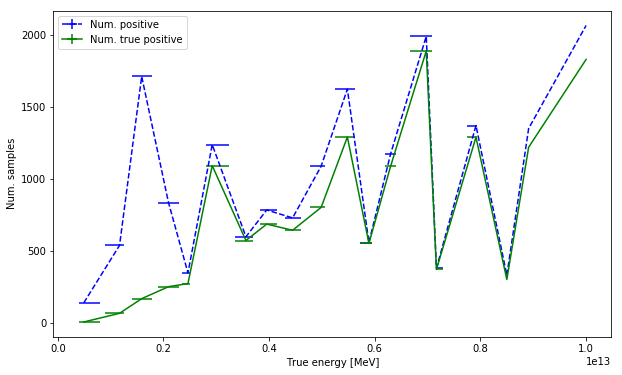

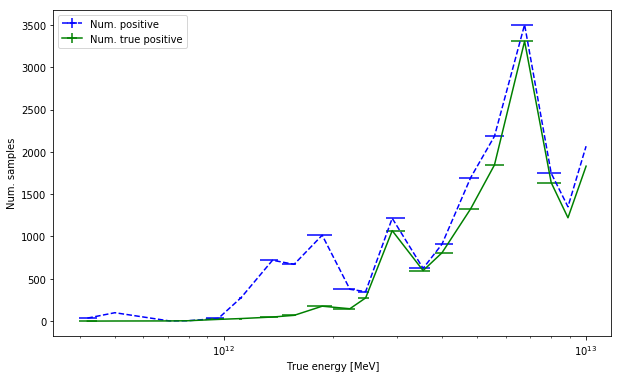

In [49]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

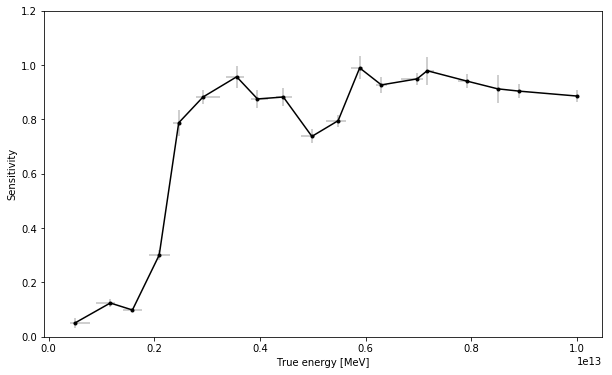

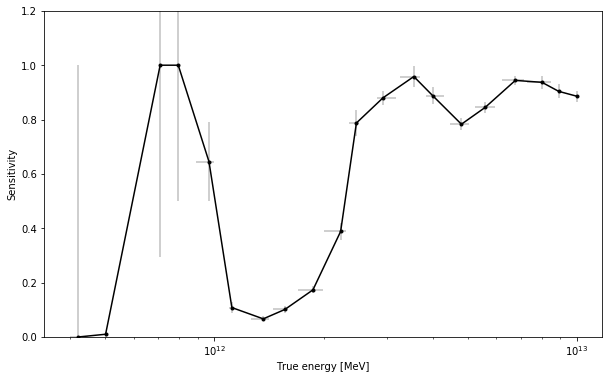

In [50]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

#### By zenith angle (theta)

In [51]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_theta = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


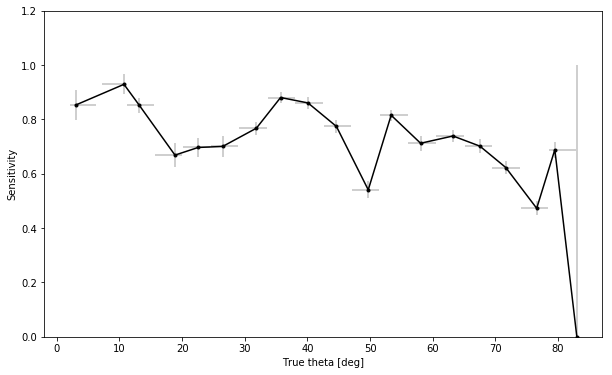

In [52]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

#### By azimuth angle (phi)

In [53]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_phi = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


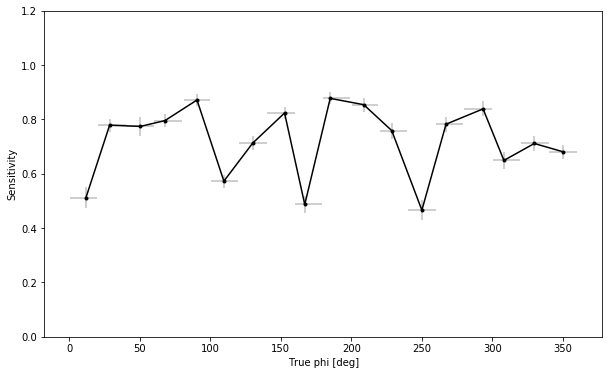

In [54]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True phi [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

### Sensitivity on L1 (bgf=1) triggered *visible track* events

#### By particle energy

In [55]:
extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_visible_tracks_nonan_df['event_id'].values, 
        simu_bgf1_visible_tracks_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


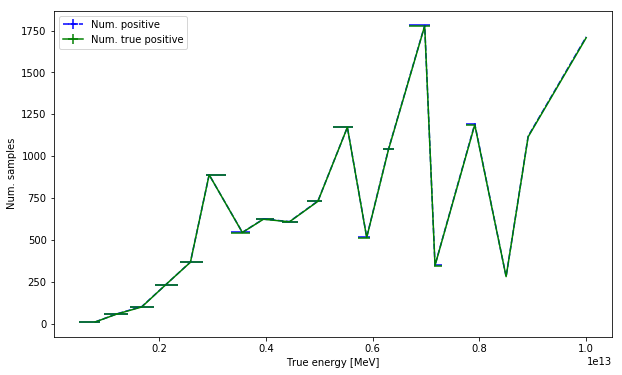

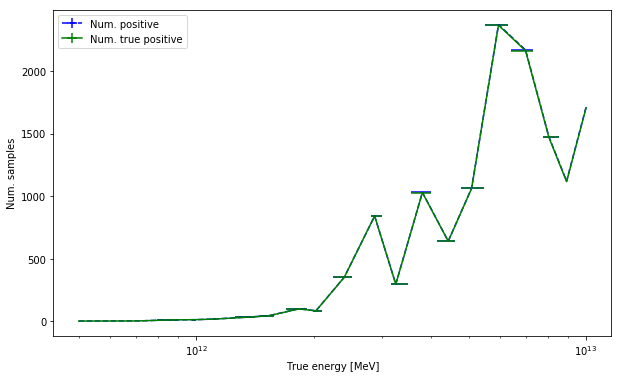

In [56]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

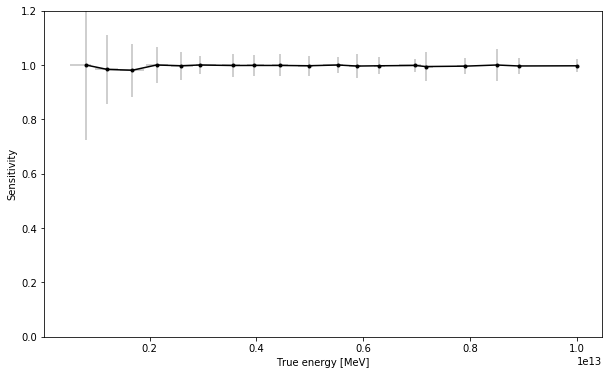

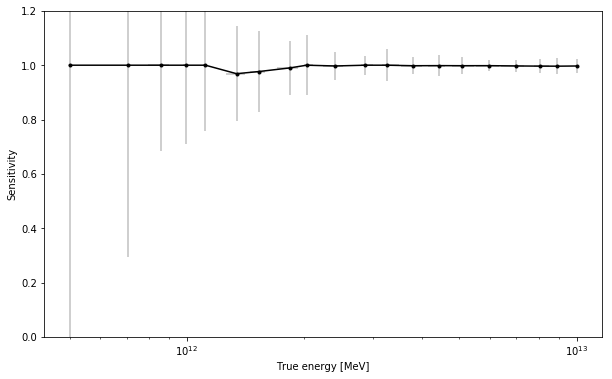

In [57]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

Most of the triggered and visible track events (training and testing data) seem to be selected.

### Sensitivity on L1 (bgf=1) triggered *track* events

#### By particle energy

In [60]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_tracks_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


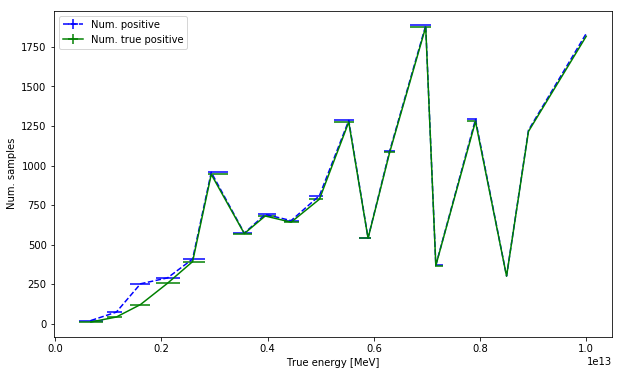

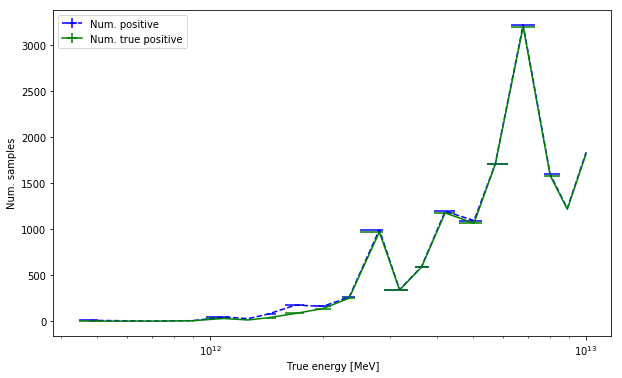

In [61]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

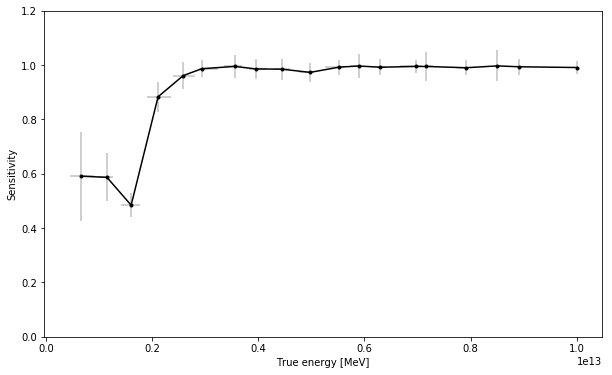

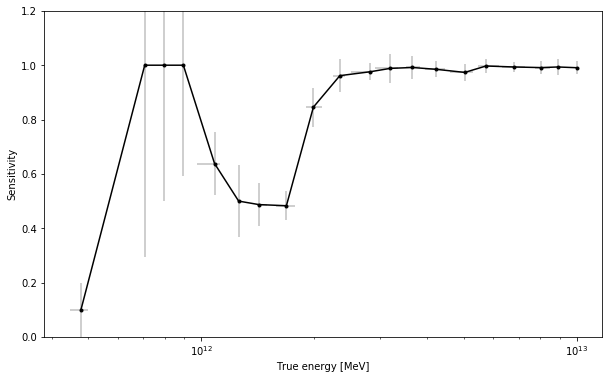

In [62]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

Low energy track events are not recognized. These events seem not to be a part of visible events dataset (selection).

In [63]:
# consistency check
print(len(simu_bgf1_tracks_nonan__rfecv_columns__y_pred))
print(len(simu_bgf1_tracks_nonan_df))

14570
14570


In [64]:
print('len(simu_bgf1_tracks_nonan_df[y_pred==0])', len(simu_bgf1_tracks_nonan_df[simu_bgf1_tracks_nonan__rfecv_columns__y_pred == 0]))
print('len(simu_bgf1_tracks_nonan_df[y_pred==1])', len(simu_bgf1_tracks_nonan_df[simu_bgf1_tracks_nonan__rfecv_columns__y_pred == 1]))

len(simu_bgf1_tracks_nonan_df[y_pred==0]) 351
len(simu_bgf1_tracks_nonan_df[y_pred==1]) 14219


In [65]:
simu_bgf1_tracks_nonan__insensitive__df = \
    simu_bgf1_tracks_nonan_df[ simu_bgf1_tracks_nonan__rfecv_columns__y_pred == 0 ].query('etruth_trueenergy > 1e12 and etruth_trueenergy < 0.25*1e13')

In [66]:
print('len(simu_bgf1_tracks_nonan__insensitive__df)', len(simu_bgf1_tracks_nonan__insensitive__df))

len(simu_bgf1_tracks_nonan__insensitive__df) 197


len(events_to_vis_df) = 197
--------------------------------------------------
#0	(0)
	event_id: 2111936
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 17
	source_file_acquisition: posz_18000000.00/energy_1.10e+12/Pseg18.2017-07-07-19h17m49s/npyconv/ev_69_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n210_m128_Cinverse_flat_average_directions_4m_flipud.npy
#0 id: 2111936
!!!! simu_gtu_start=-7 simu_gtu_end=10


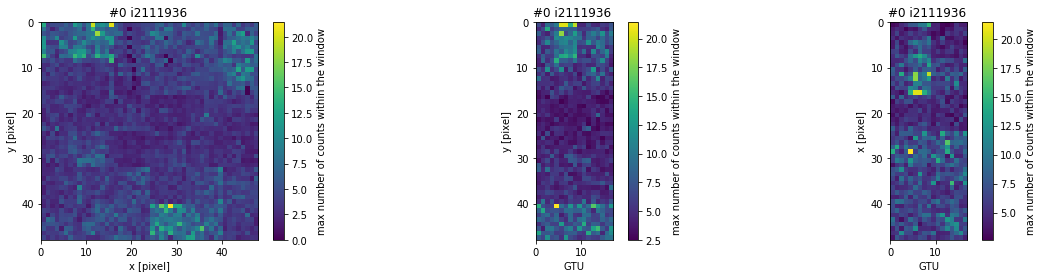

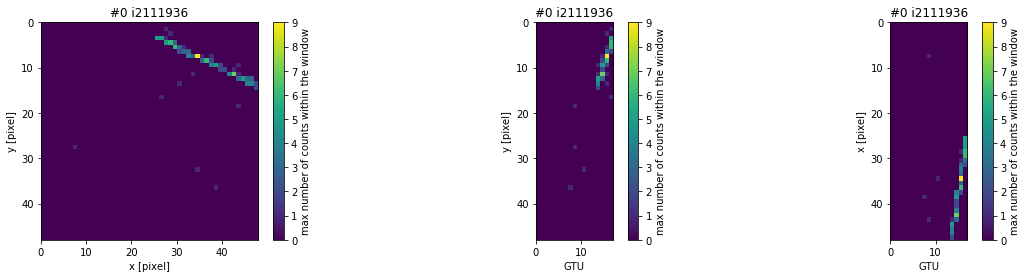

#1	(0)
	event_id: 2130077
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 13
	source_file_acquisition: posz_18000000.00/energy_1.10e+12/Pseg18/npyconv/ev_97_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n328_m128_Cinverse_flat_average_directions_4m_flipud.npy
#1 id: 2130077
!!!! simu_gtu_start=-1 simu_gtu_end=12


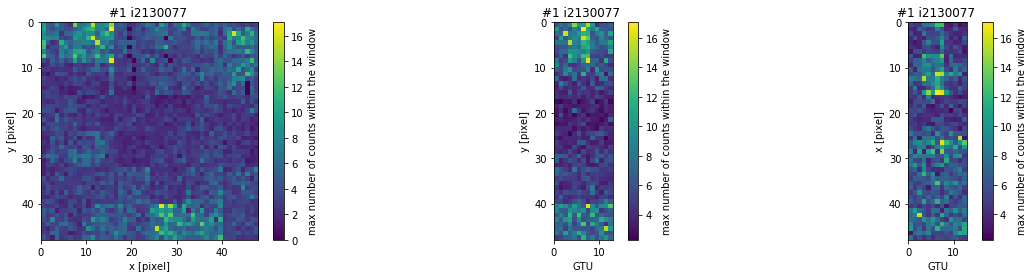

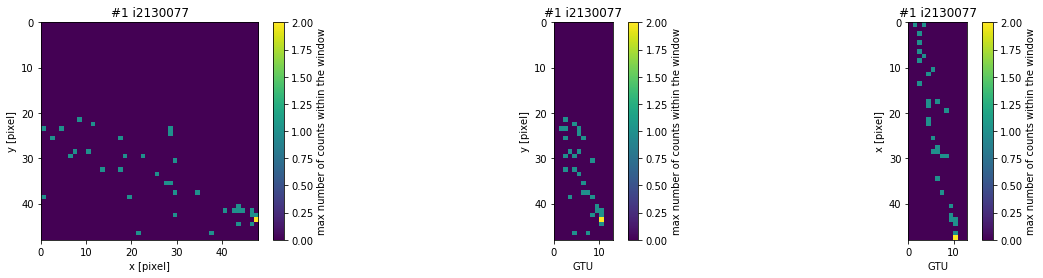

#2	(0)
	event_id: 32492
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.12e+12/thousnd27E1.2017-07-24-13h36m26s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170503-085415-001.001_k1_s0_d32_n309_m128_Cinverse_flat_average_directions_4m_flipud.npy
#2 id: 32492
!!!! simu_gtu_start=-8 simu_gtu_end=6


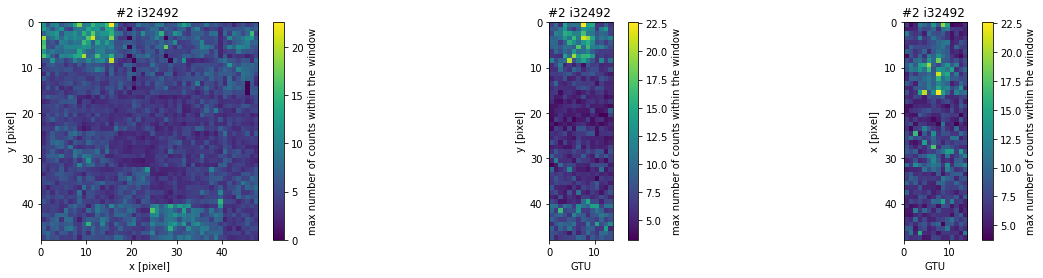

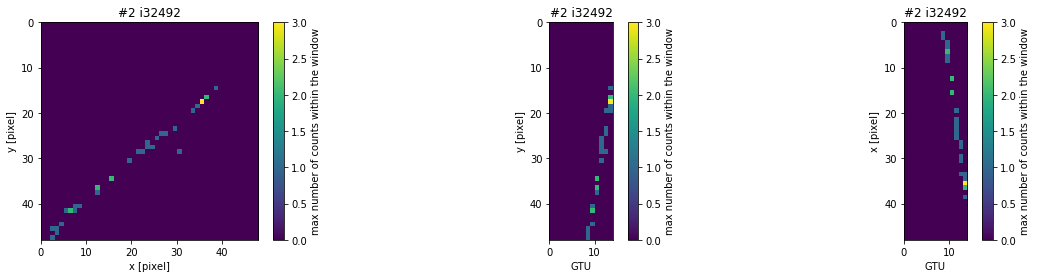

#3	(0)
	event_id: 2083086
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 14
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1/npyconv/ev_24_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n448_m128_Cinverse_flat_average_directions_4m_flipud.npy
#3 id: 2083086
!!!! simu_gtu_start=-7 simu_gtu_end=7


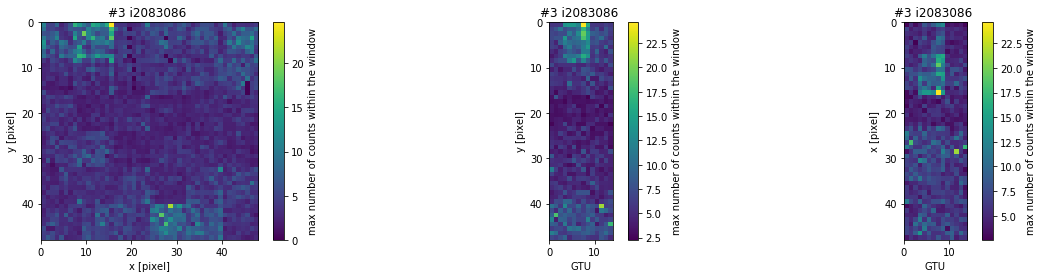

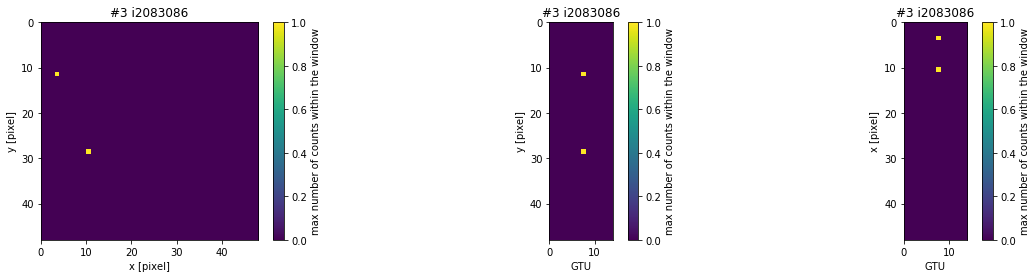

#4	(0)
	event_id: 2082778
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 18
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n442_m128_Cinverse_flat_average_directions_4m_flipud.npy
#4 id: 2082778
!!!! simu_gtu_start=-4 simu_gtu_end=14


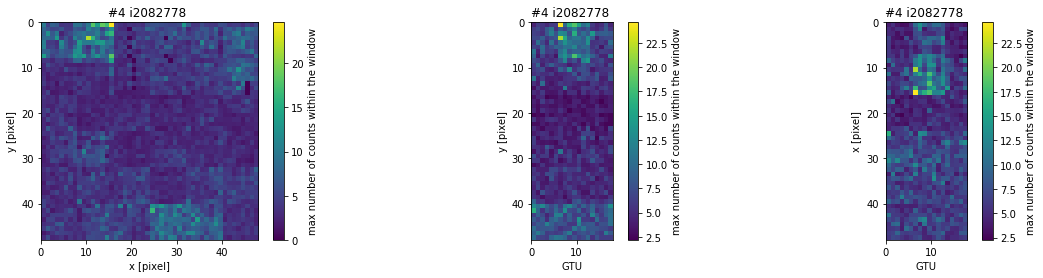

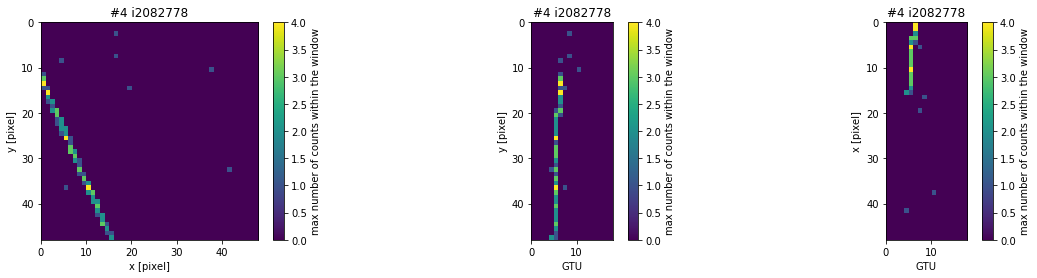

#5	(0)
	event_id: 2081755
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 15
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h46m04s/npyconv/ev_47_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n431_m128_Cinverse_flat_average_directions_4m_flipud.npy
#5 id: 2081755
!!!! simu_gtu_start=-3 simu_gtu_end=12


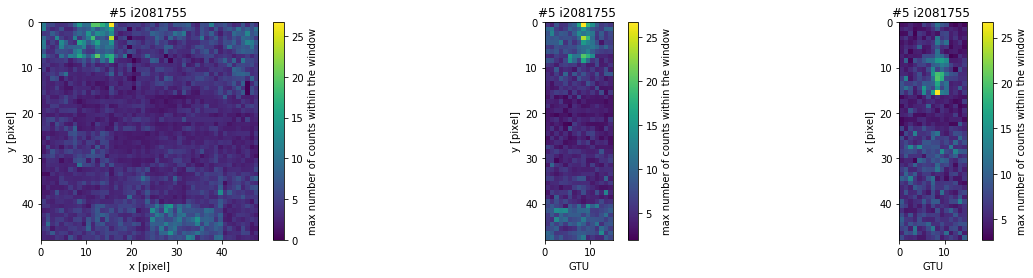

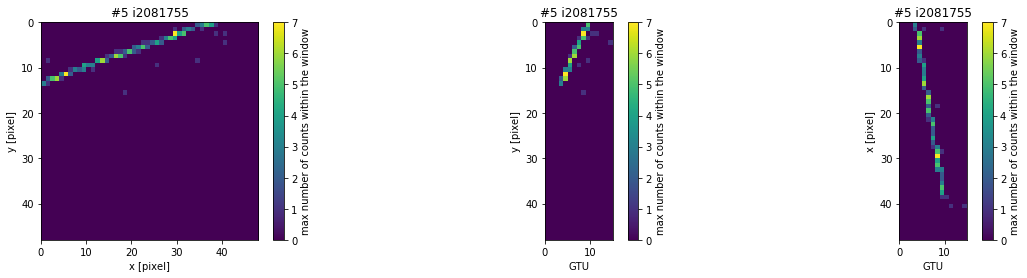

#6	(0)
	event_id: 2078801
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 9
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h30m11s/npyconv/ev_66_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n392_m128_Cinverse_flat_average_directions_4m_flipud.npy
#6 id: 2078801
!!!! simu_gtu_start=-3 simu_gtu_end=6


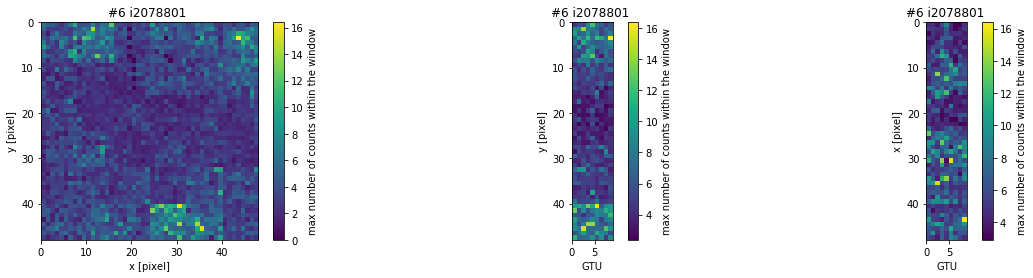

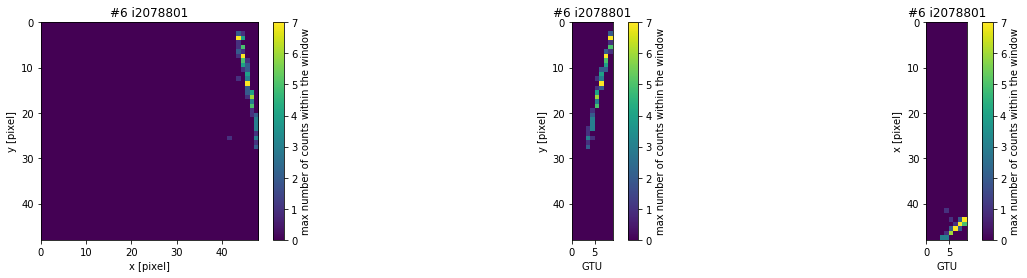

#7	(0)
	event_id: 2078104
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 11
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h30m11s/npyconv/ev_21_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n383_m128_Cinverse_flat_average_directions_4m_flipud.npy
#7 id: 2078104
!!!! simu_gtu_start=-4 simu_gtu_end=7


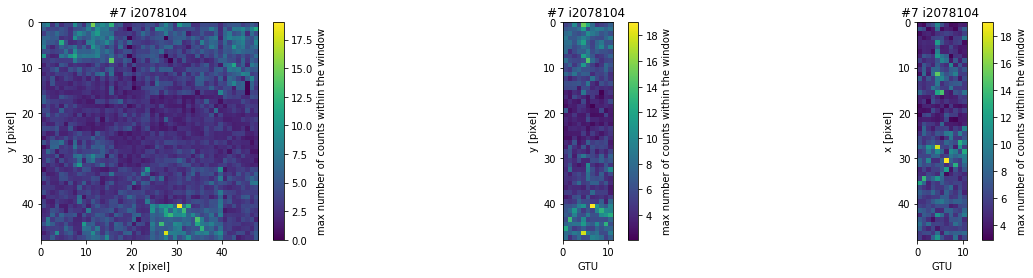

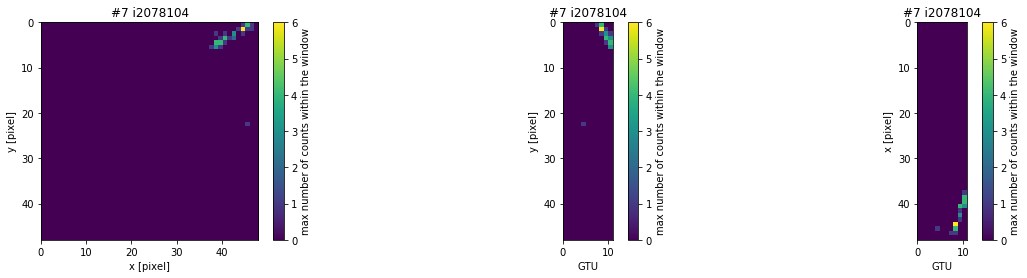

#8	(0)
	event_id: 2074941
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 15
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h07m59s/npyconv/ev_7_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n319_m128_Cinverse_flat_average_directions_4m_flipud.npy
#8 id: 2074941
!!!! simu_gtu_start=-8 simu_gtu_end=7


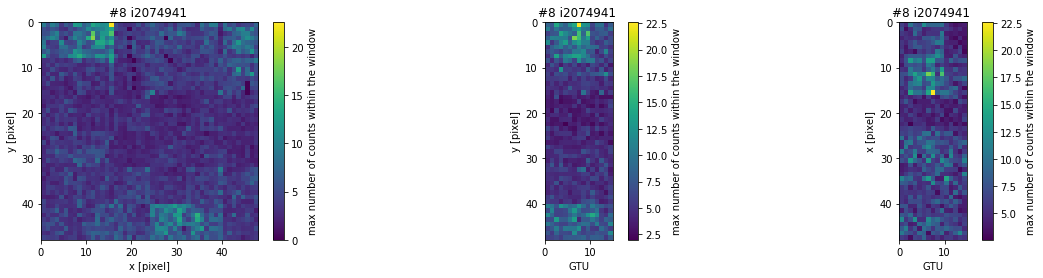

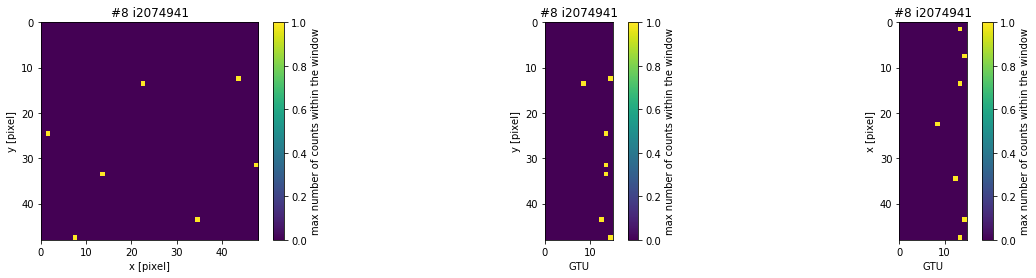

#9	(0)
	event_id: 2073223
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 15
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-16h51m38s/npyconv/ev_90_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n295_m128_Cinverse_flat_average_directions_4m_flipud.npy
#9 id: 2073223
!!!! simu_gtu_start=-8 simu_gtu_end=7


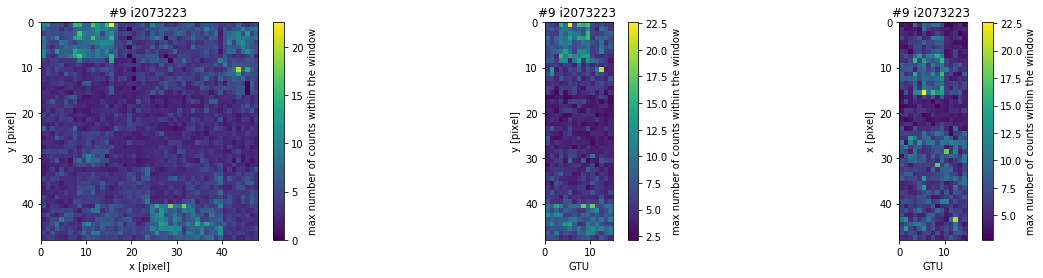

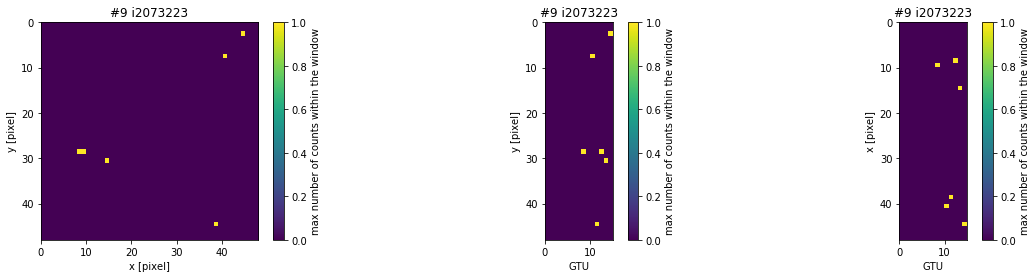

#0	(0)
	event_id: 2548350
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 15
	source_file_acquisition: posz_33000000.00/energy_1.41e+12/thousnd33E3/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n319_m128_Cinverse_flat_average_directions_4m_flipud.npy
#0 id: 2548350
!!!! simu_gtu_start=-8 simu_gtu_end=7


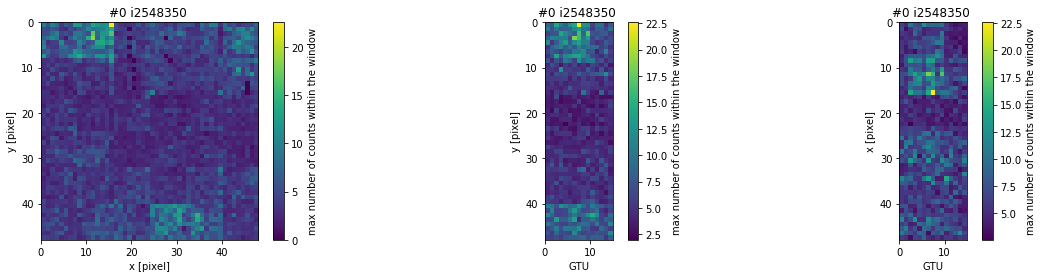

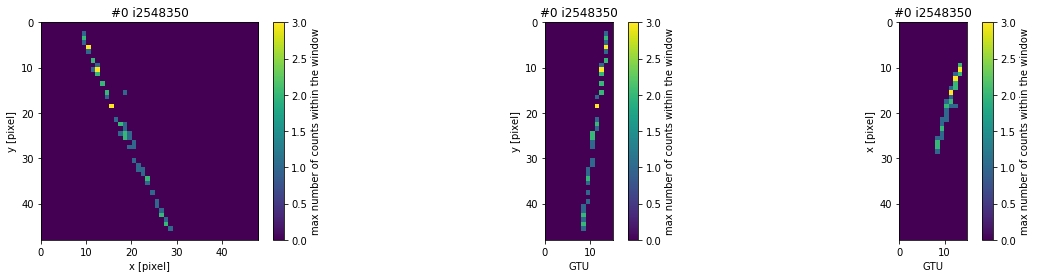

#1	(0)
	event_id: 2548363
	packet_id: 1
	gtu_in_packet: 58
	num_gtu: 15
	source_file_acquisition: posz_33000000.00/energy_1.41e+12/thousnd33E3/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n319_m128_Cinverse_flat_average_directions_4m_flipud.npy
#1 id: 2548363
!!!! simu_gtu_start=24 simu_gtu_end=39


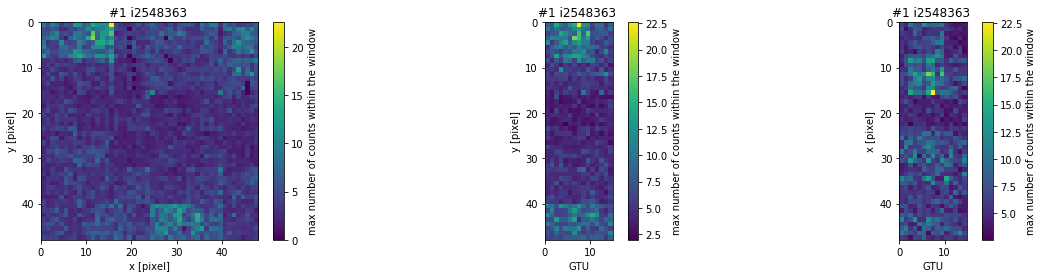

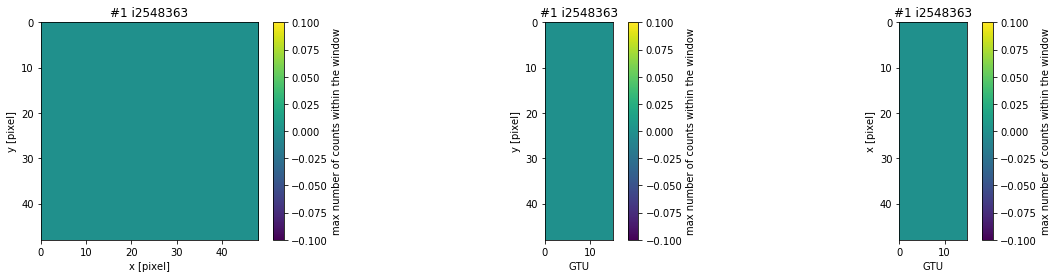

#2	(0)
	event_id: 2548644
	packet_id: 1
	gtu_in_packet: 25
	num_gtu: 15
	source_file_acquisition: posz_33000000.00/energy_1.41e+12/thousnd33E3/npyconv/ev_67_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n336_m128_Cinverse_flat_average_directions_4m_flipud.npy
#2 id: 2548644
!!!! simu_gtu_start=-9 simu_gtu_end=6


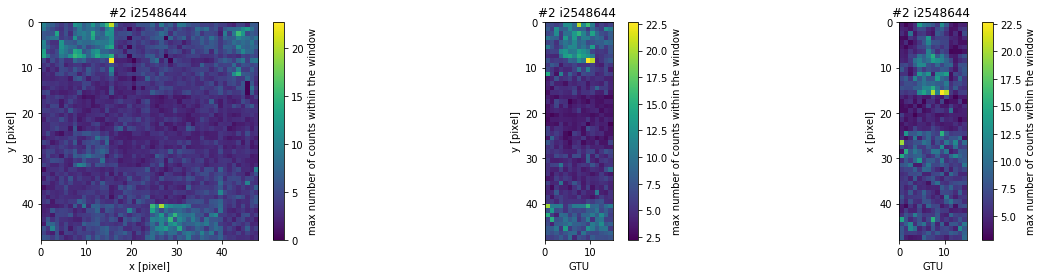

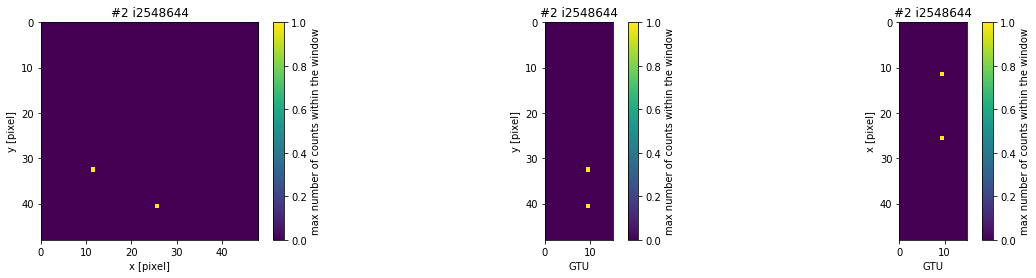

#3	(0)
	event_id: 2548652
	packet_id: 1
	gtu_in_packet: 57
	num_gtu: 15
	source_file_acquisition: posz_33000000.00/energy_1.41e+12/thousnd33E3/npyconv/ev_67_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n336_m128_Cinverse_flat_average_directions_4m_flipud.npy
#3 id: 2548652
!!!! simu_gtu_start=23 simu_gtu_end=38


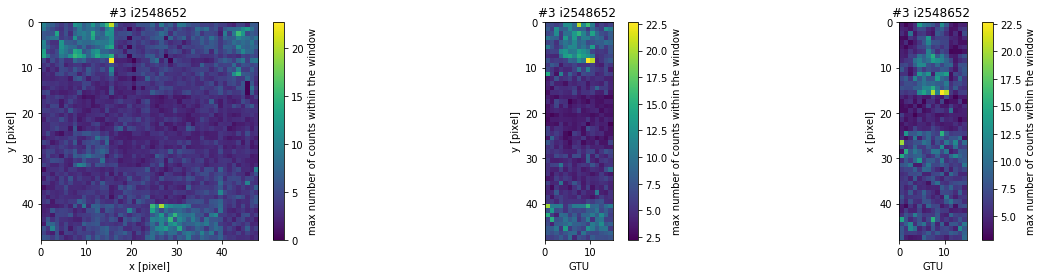

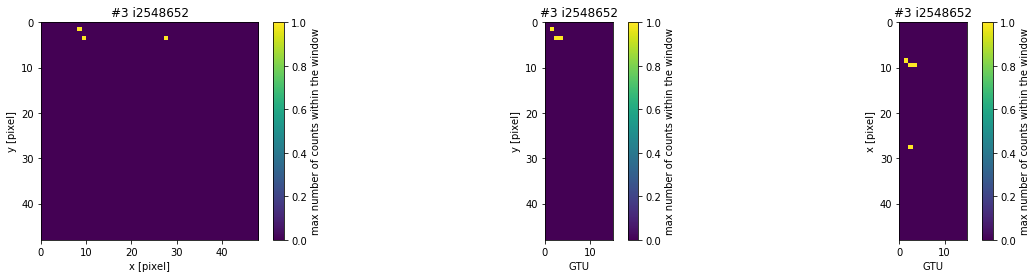

#4	(0)
	event_id: 2156813
	packet_id: 1
	gtu_in_packet: 24
	num_gtu: 21
	source_file_acquisition: posz_30000000.00/energy_1.41e+12/thousnd30E3.2017-07-24-19h09m07s/npyconv/ev_80_mc_1__signals_p128_a0_g30_f128_b20170503-085415-001.001_k1_s0_d32_n324_m128_Cinverse_flat_average_directions_4m_flipud.npy
#4 id: 2156813
!!!! simu_gtu_start=-10 simu_gtu_end=11


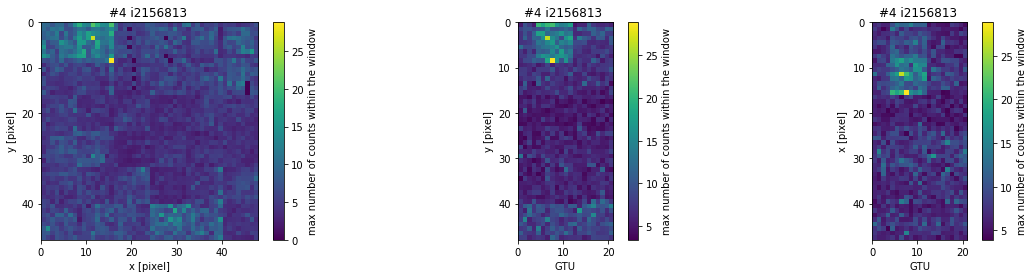

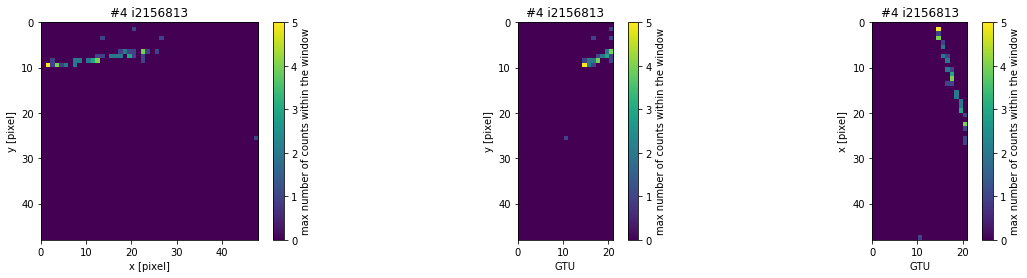

#5	(0)
	event_id: 2111425
	packet_id: 1
	gtu_in_packet: 50
	num_gtu: 11
	source_file_acquisition: posz_21000000.00/energy_1.41e+12/thousnd21E3/npyconv/ev_10_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n888_m128_Cinverse_flat_average_directions_4m_flipud.npy
#5 id: 2111425
!!!! simu_gtu_start=16 simu_gtu_end=27


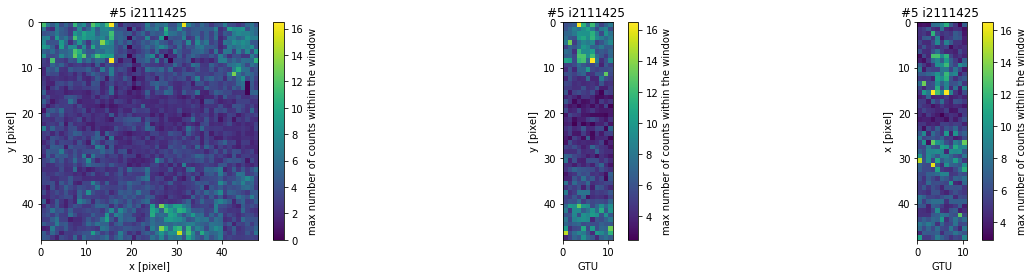

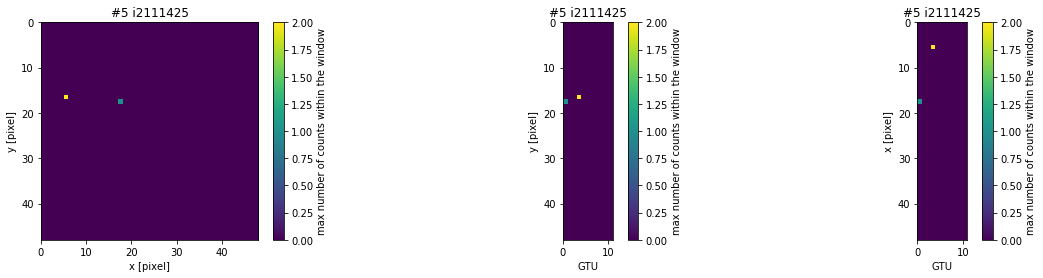

#6	(0)
	event_id: 35899
	packet_id: 1
	gtu_in_packet: 65
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.41e+12/thousnd27E3.2017-07-24-15h49m12s/npyconv/ev_89_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n197_m128_Cinverse_flat_average_directions_4m_flipud.npy
#6 id: 35899
!!!! simu_gtu_start=31 simu_gtu_end=45


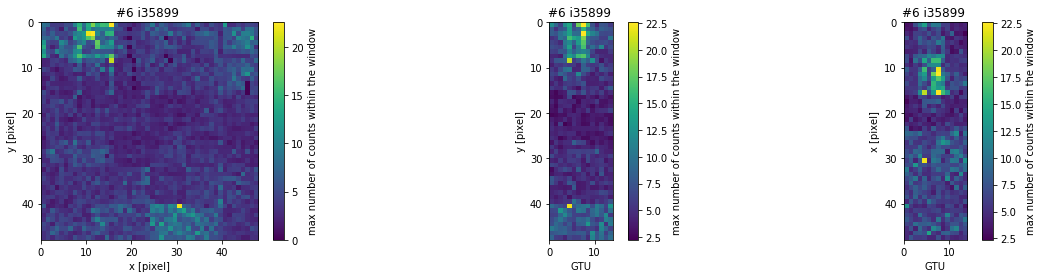

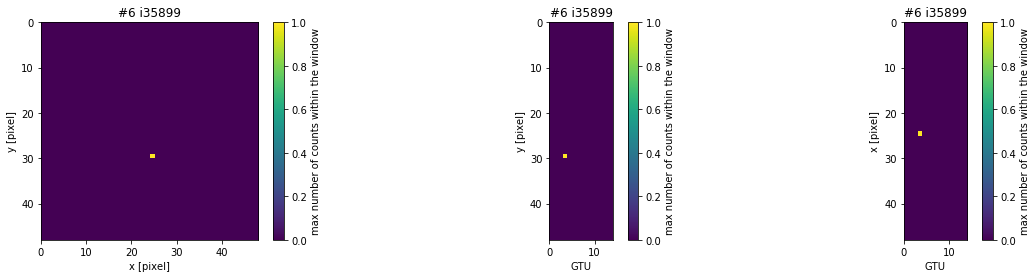

#7	(0)
	event_id: 2084664
	packet_id: 1
	gtu_in_packet: 40
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.41e+12/thousnd30E3/npyconv/ev_67_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n323_m128_Cinverse_flat_average_directions_4m_flipud.npy
#7 id: 2084664
!!!! simu_gtu_start=6 simu_gtu_end=20


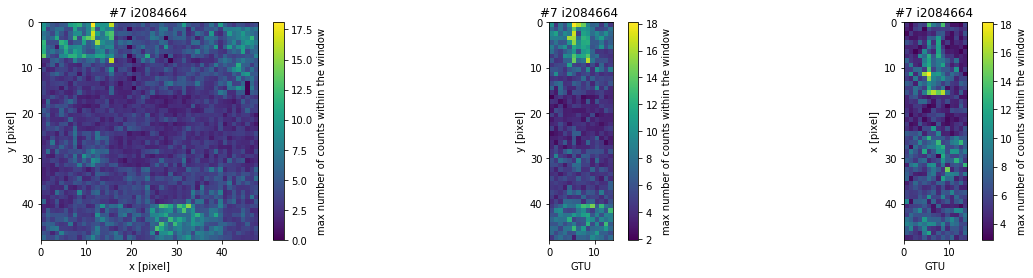

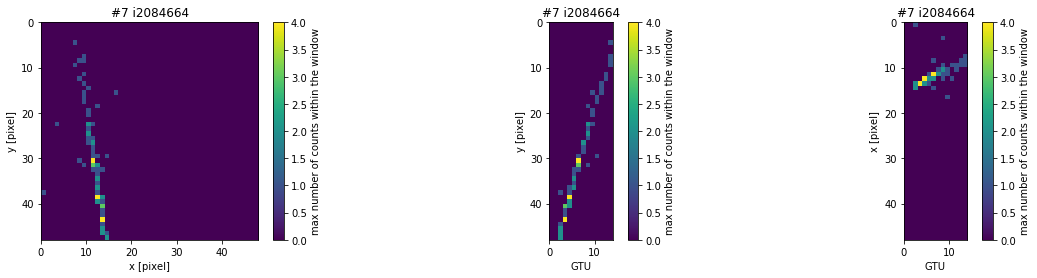

#8	(0)
	event_id: 2079769
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 12
	source_file_acquisition: posz_30000000.00/energy_1.41e+12/thousnd30E3.2017-07-24-19h46m31s/npyconv/ev_81_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n281_m128_Cinverse_flat_average_directions_4m_flipud.npy
#8 id: 2079769
!!!! simu_gtu_start=10 simu_gtu_end=22


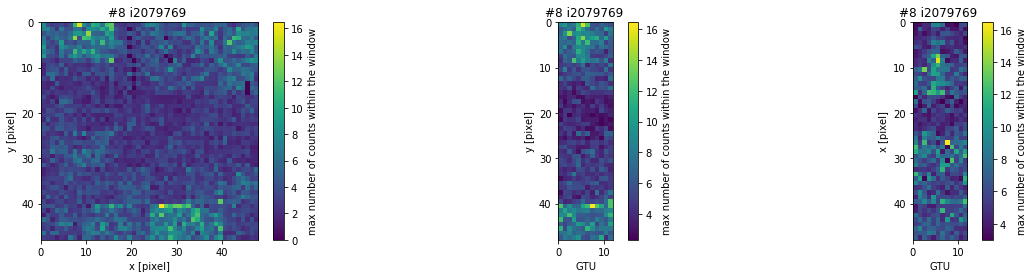

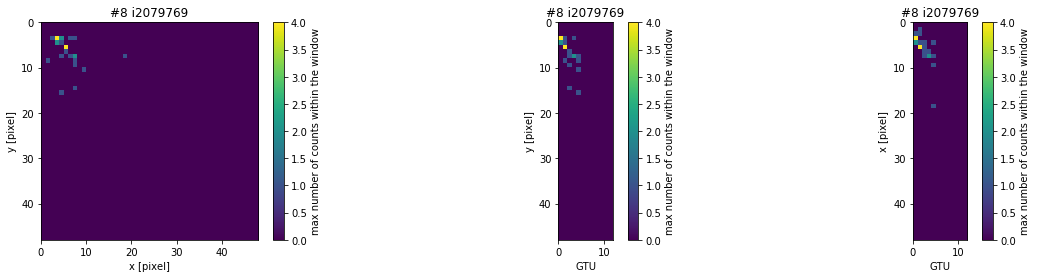

#9	(0)
	event_id: 2077152
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 10
	source_file_acquisition: posz_30000000.00/energy_1.41e+12/thousnd30E3.2017-07-24-19h38m46s/npyconv/ev_96_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n257_m128_Cinverse_flat_average_directions_4m_flipud.npy
#9 id: 2077152
!!!! simu_gtu_start=-1 simu_gtu_end=9


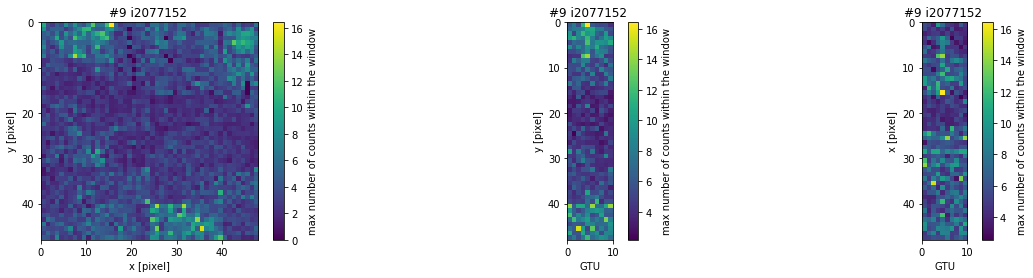

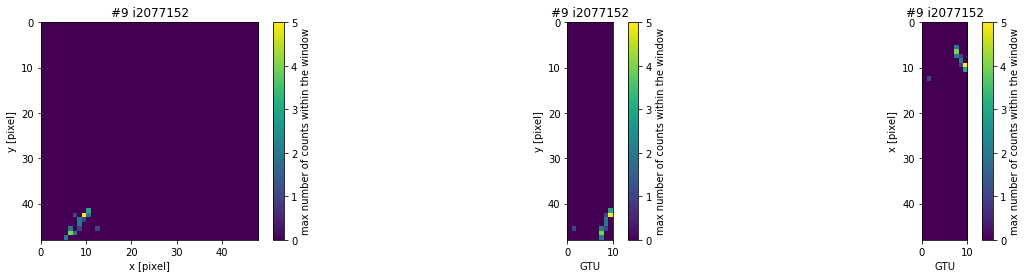

#0	(0)
	event_id: 2556756
	packet_id: 1
	gtu_in_packet: 65
	num_gtu: 11
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4/npyconv/ev_89_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n630_m128_Cinverse_flat_average_directions_4m_flipud.npy
#0 id: 2556756
!!!! simu_gtu_start=31 simu_gtu_end=42


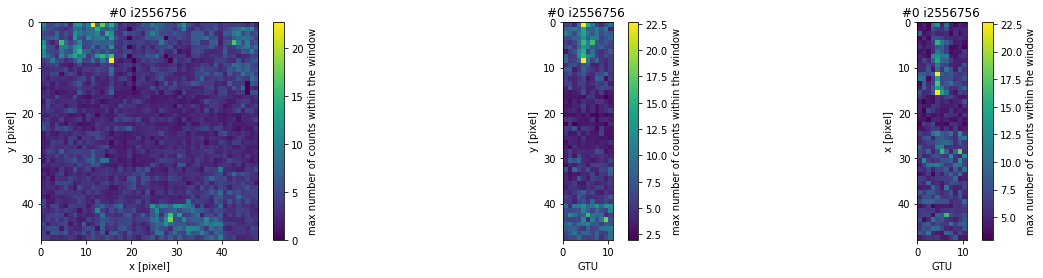

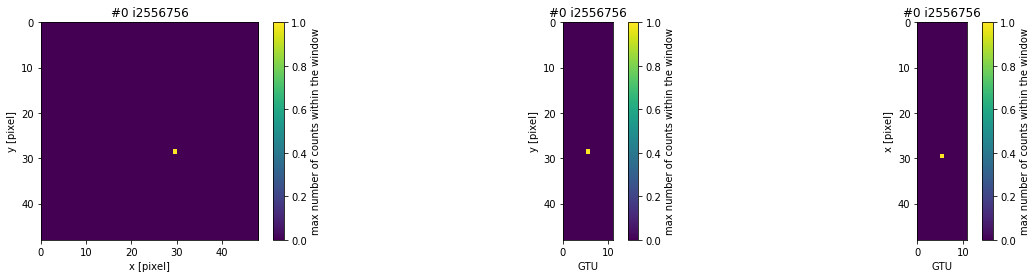

#1	(0)
	event_id: 2117301
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 11
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4/npyconv/ev_31_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n580_m128_Cinverse_flat_average_directions_4m_flipud.npy
#1 id: 2117301
!!!! simu_gtu_start=-4 simu_gtu_end=7


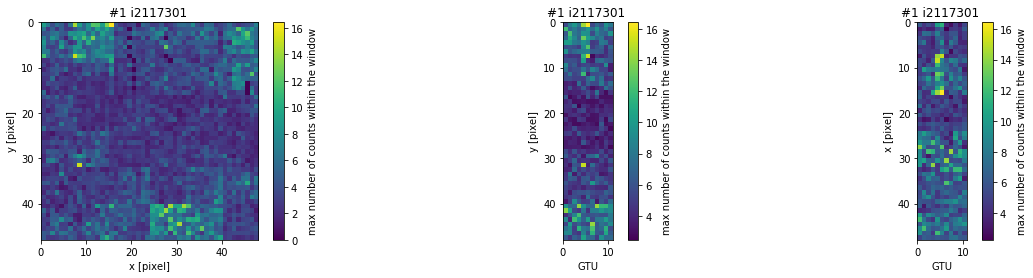

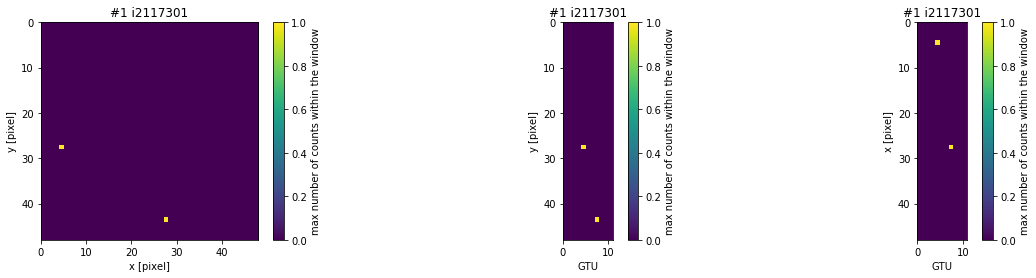

#2	(0)
	event_id: 2117126
	packet_id: 1
	gtu_in_packet: 25
	num_gtu: 17
	source_file_acquisition: posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-21h08m56s/npyconv/ev_44_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n1007_m128_Cinverse_flat_average_directions_4m_flipud.npy
#2 id: 2117126
!!!! simu_gtu_start=-9 simu_gtu_end=8


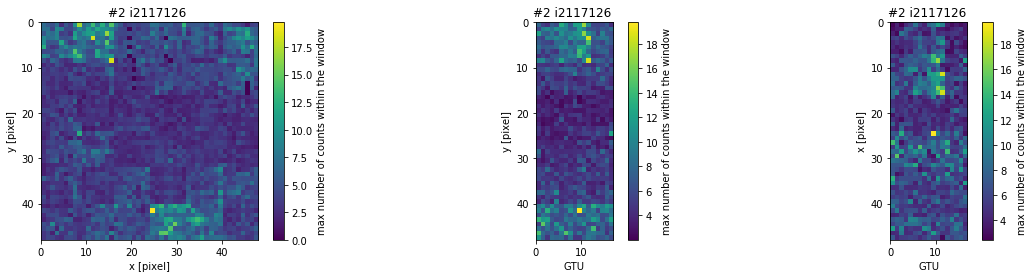

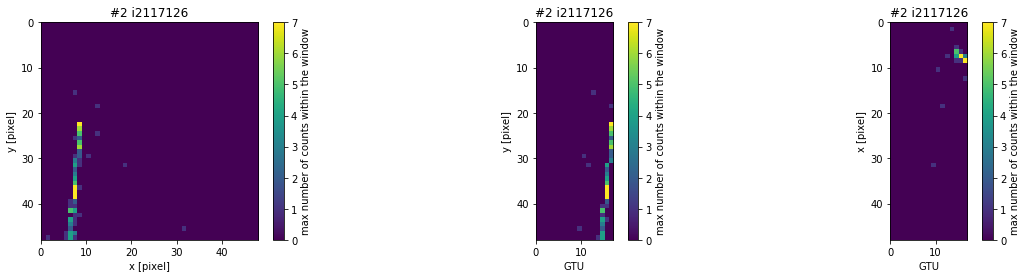

#3	(0)
	event_id: 2115141
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 14
	source_file_acquisition: posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-20h53m09s/npyconv/ev_10_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n961_m128_Cinverse_flat_average_directions_4m_flipud.npy
#3 id: 2115141
!!!! simu_gtu_start=-7 simu_gtu_end=7


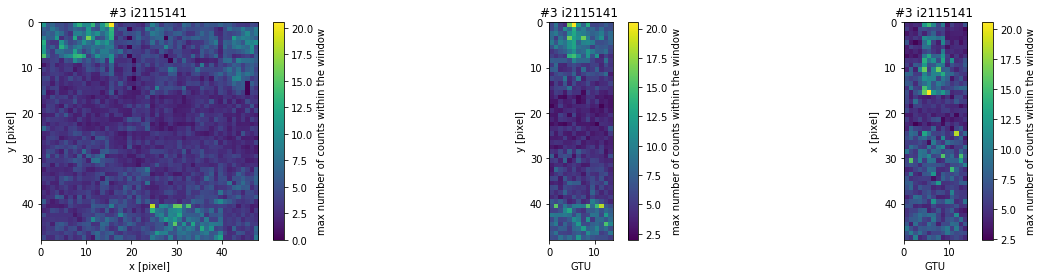

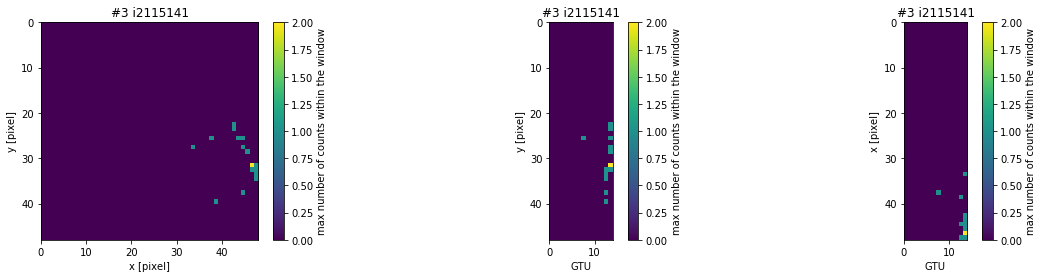

#4	(0)
	event_id: 2118736
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 12
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4/npyconv/ev_98_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n597_m128_Cinverse_flat_average_directions_4m_flipud.npy
#4 id: 2118736
!!!! simu_gtu_start=-1 simu_gtu_end=11


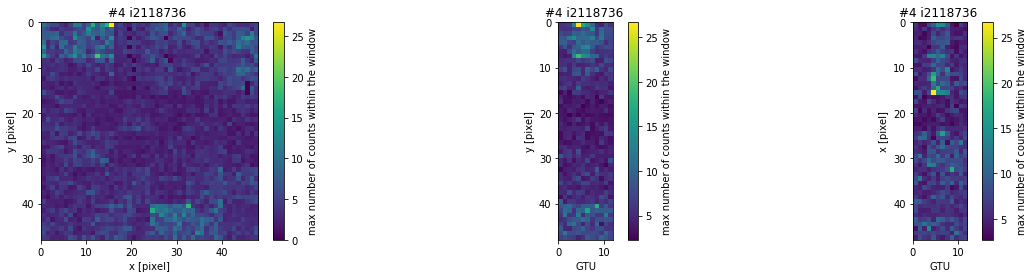

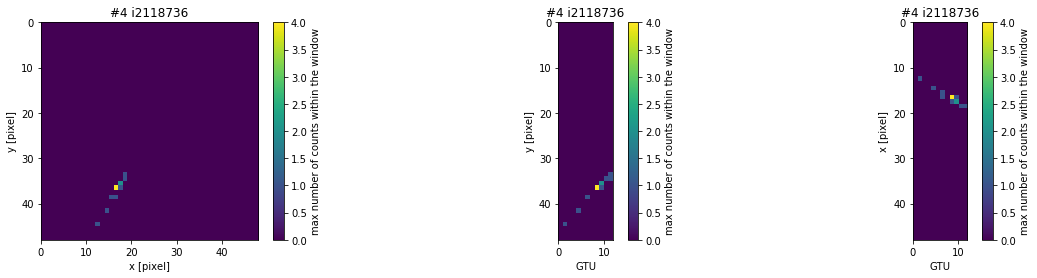

#5	(0)
	event_id: 2555313
	packet_id: 1
	gtu_in_packet: 29
	num_gtu: 12
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-16h02m32s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n552_m128_Cinverse_flat_average_directions_4m_flipud.npy
#5 id: 2555313
!!!! simu_gtu_start=-5 simu_gtu_end=7


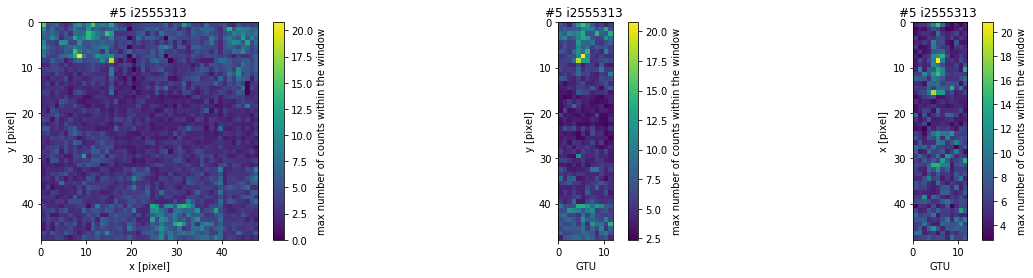

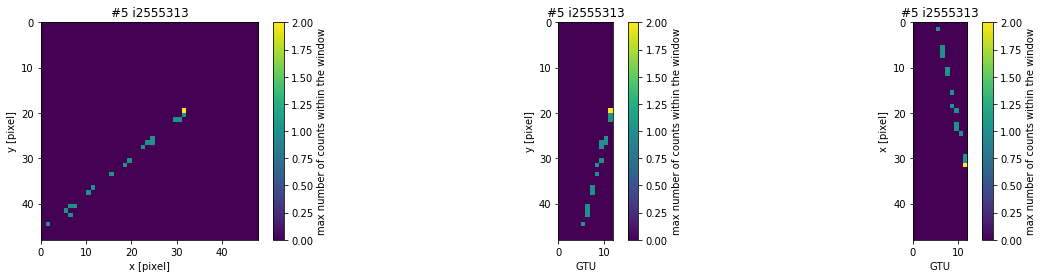

#6	(0)
	event_id: 2111805
	packet_id: 1
	gtu_in_packet: 25
	num_gtu: 15
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/npyconv/ev_65_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n536_m128_Cinverse_flat_average_directions_4m_flipud.npy
#6 id: 2111805
!!!! simu_gtu_start=-9 simu_gtu_end=6


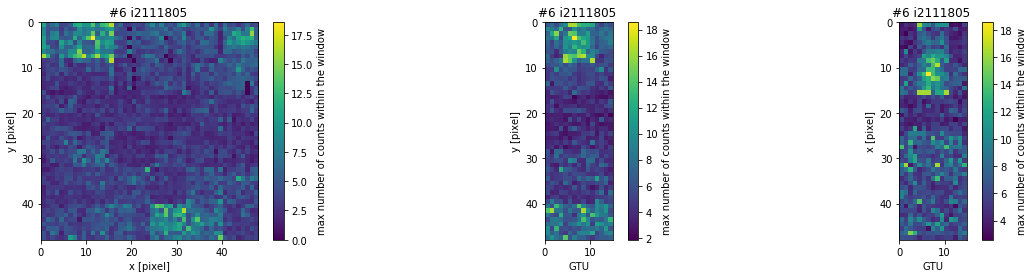

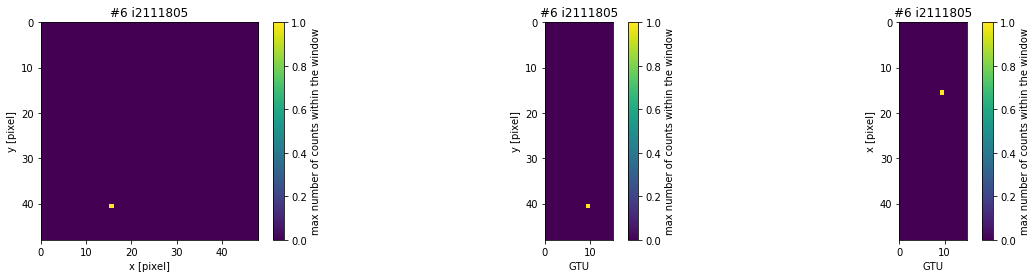

#7	(0)
	event_id: 2268450
	packet_id: 1
	gtu_in_packet: 32
	num_gtu: 10
	source_file_acquisition: posz_18000000.00/energy_1.58e+12/thousnd18E4.2017-07-27-17h20m46s/npyconv/ev_21_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n1257_m128_Cinverse_flat_average_directions_4m_flipud.npy
#7 id: 2268450
!!!! simu_gtu_start=-2 simu_gtu_end=8


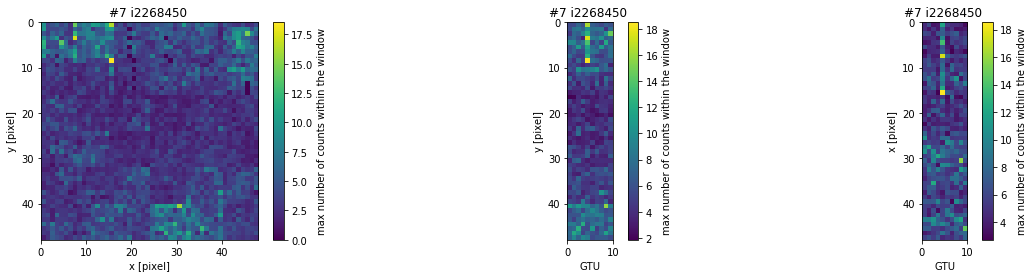

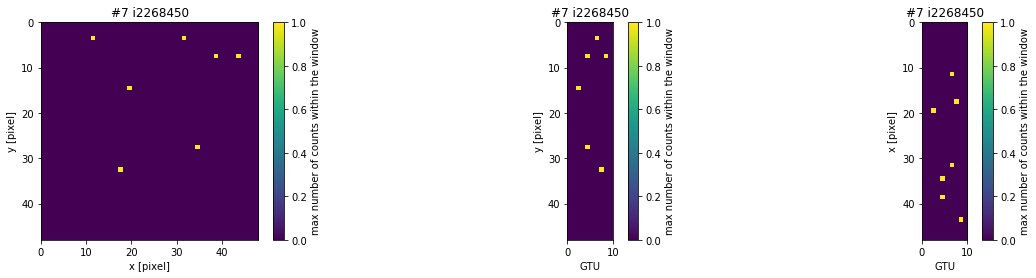

#8	(0)
	event_id: 2554842
	packet_id: 1
	gtu_in_packet: 25
	num_gtu: 15
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-15h54m45s/npyconv/ev_66_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n536_m128_Cinverse_flat_average_directions_4m_flipud.npy
#8 id: 2554842
!!!! simu_gtu_start=-9 simu_gtu_end=6


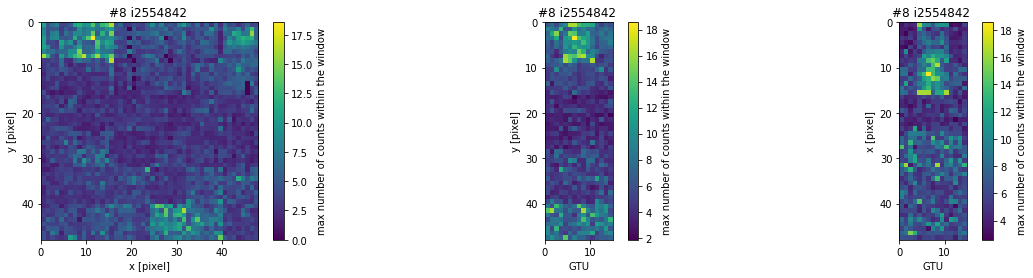

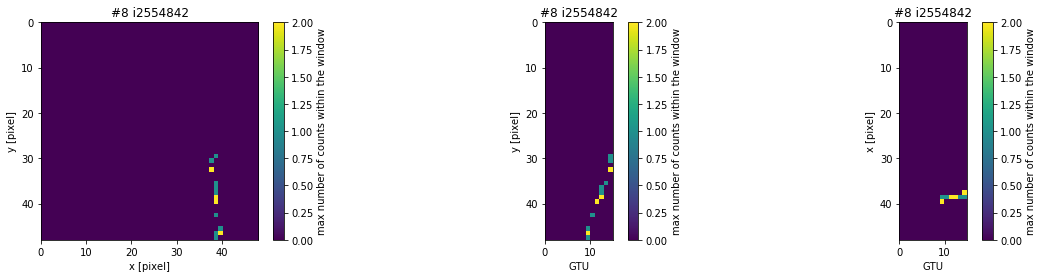

#9	(0)
	event_id: 2110182
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 16
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n524_m128_Cinverse_flat_average_directions_4m_flipud.npy
#9 id: 2110182
!!!! simu_gtu_start=-7 simu_gtu_end=9


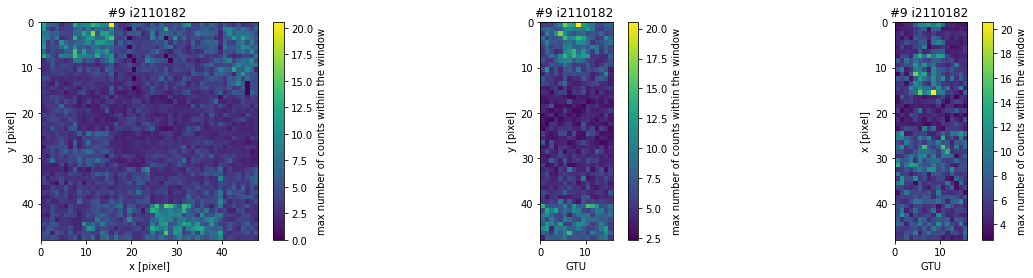

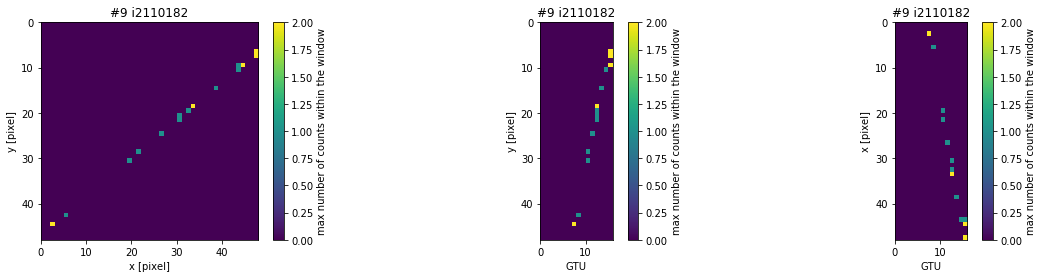

#0	(0)
	event_id: 2148315
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n845_m128_Cinverse_flat_average_directions_4m_flipud.npy
#0 id: 2148315
!!!! simu_gtu_start=-8 simu_gtu_end=6


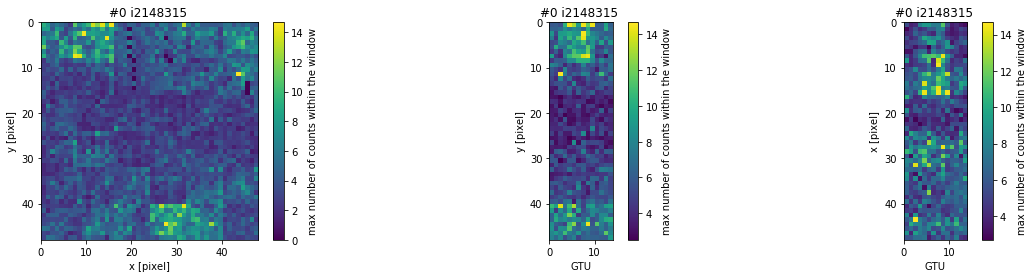

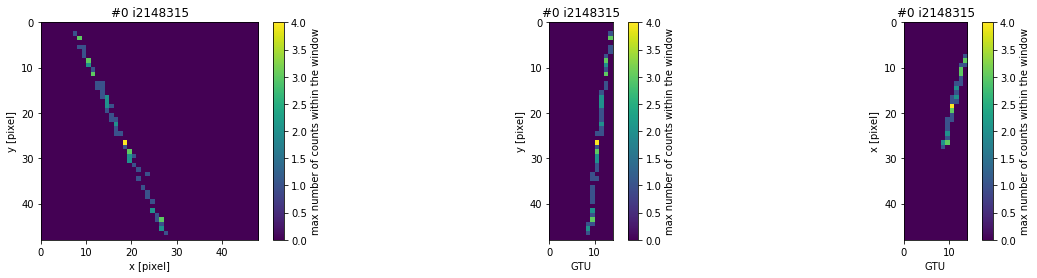

#1	(0)
	event_id: 2150085
	packet_id: 1
	gtu_in_packet: 29
	num_gtu: 12
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5/npyconv/ev_74_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n869_m128_Cinverse_flat_average_directions_4m_flipud.npy
#1 id: 2150085
!!!! simu_gtu_start=-5 simu_gtu_end=7


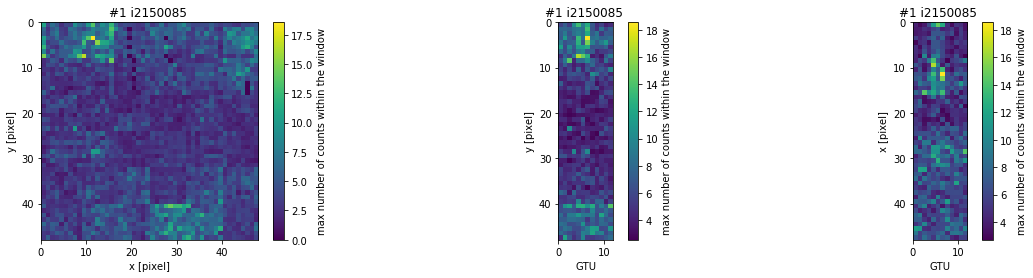

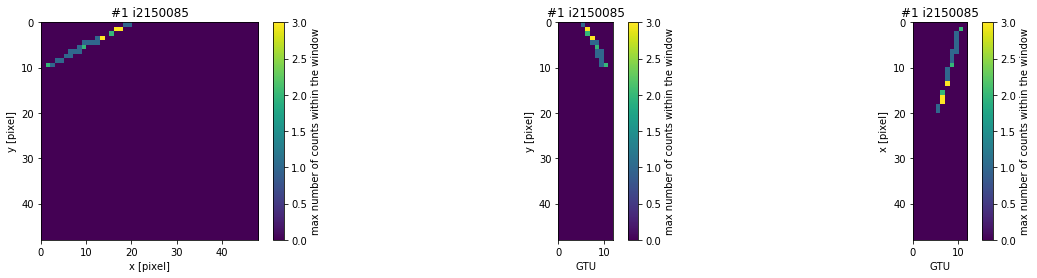

#2	(0)
	event_id: 54842
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-18h43m47s/npyconv/ev_83_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n845_m128_Cinverse_flat_average_directions_4m_flipud.npy
#2 id: 54842
!!!! simu_gtu_start=-8 simu_gtu_end=6


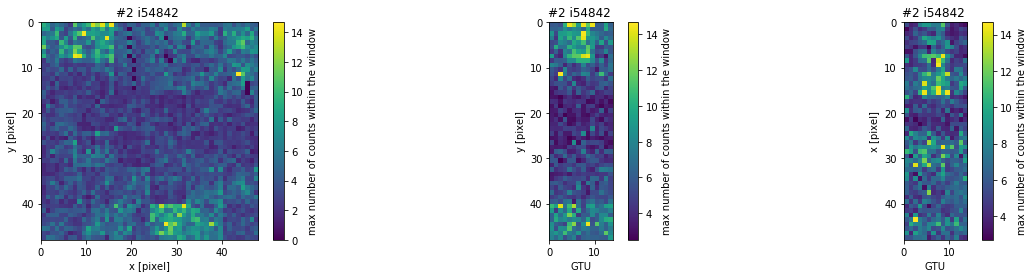

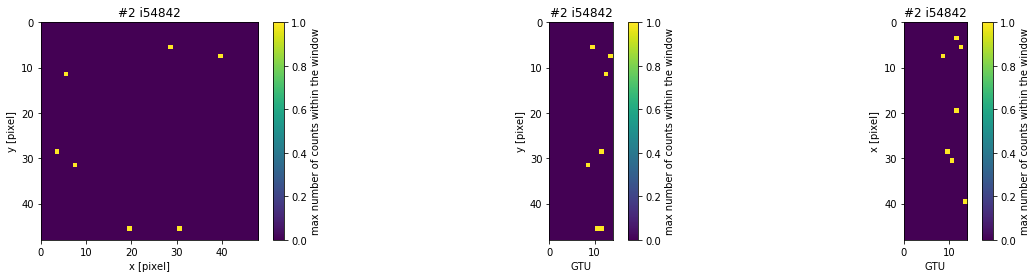

#3	(0)
	event_id: 2569182
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 14
	source_file_acquisition: posz_33000000.00/energy_1.78e+12/thousnd33E5/npyconv/ev_24_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n874_m128_Cinverse_flat_average_directions_4m_flipud.npy
#3 id: 2569182
!!!! simu_gtu_start=-7 simu_gtu_end=7


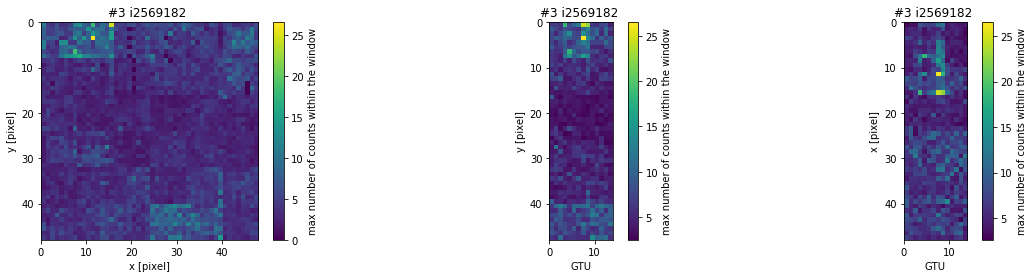

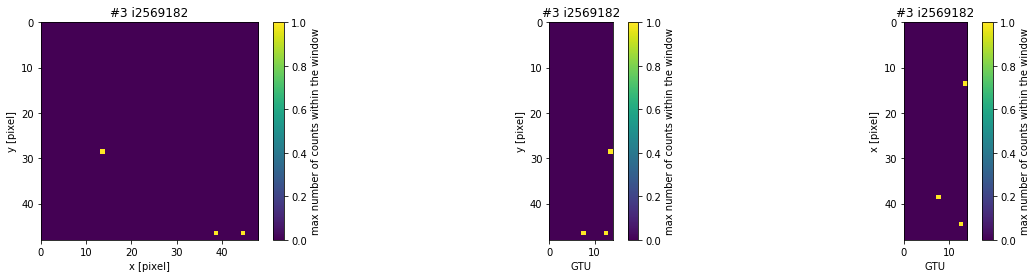

#4	(0)
	event_id: 54601
	packet_id: 1
	gtu_in_packet: 28
	num_gtu: 11
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-18h43m47s/npyconv/ev_71_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n834_m128_Cinverse_flat_average_directions_4m_flipud.npy
#4 id: 54601
!!!! simu_gtu_start=-6 simu_gtu_end=5


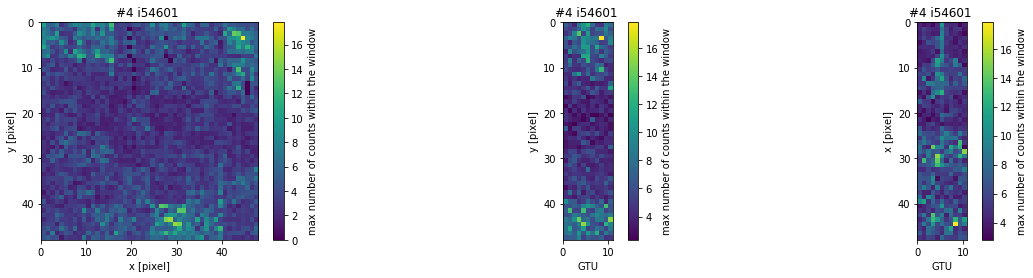

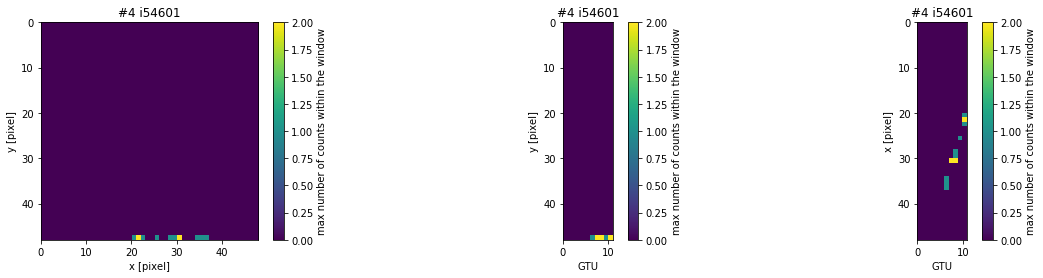

#5	(0)
	event_id: 53032
	packet_id: 1
	gtu_in_packet: 59
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-18h28m06s/npyconv/ev_83_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n778_m128_Cinverse_flat_average_directions_4m_flipud.npy
#5 id: 53032
!!!! simu_gtu_start=25 simu_gtu_end=39


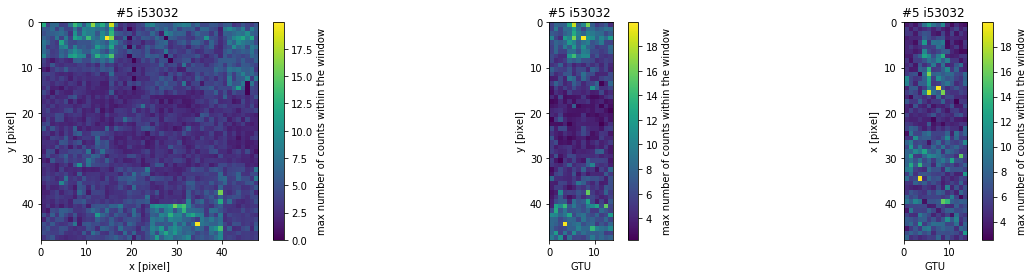

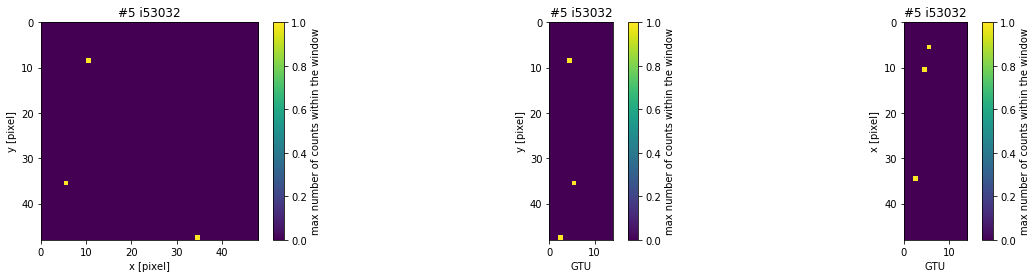

#6	(0)
	event_id: 53015
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-18h28m06s/npyconv/ev_83_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n778_m128_Cinverse_flat_average_directions_4m_flipud.npy
#6 id: 53015
!!!! simu_gtu_start=-7 simu_gtu_end=7


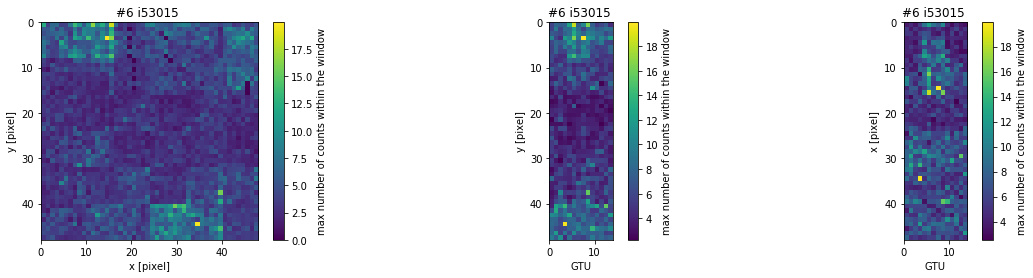

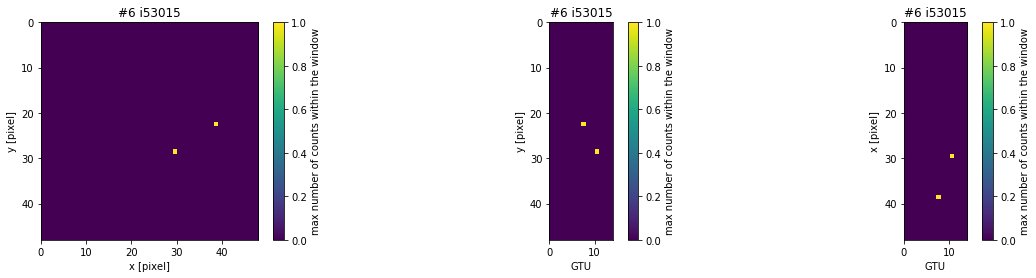

#7	(0)
	event_id: 52307
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 16
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-18h28m06s/npyconv/ev_11_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n758_m128_Cinverse_flat_average_directions_4m_flipud.npy
#7 id: 52307
!!!! simu_gtu_start=-4 simu_gtu_end=12


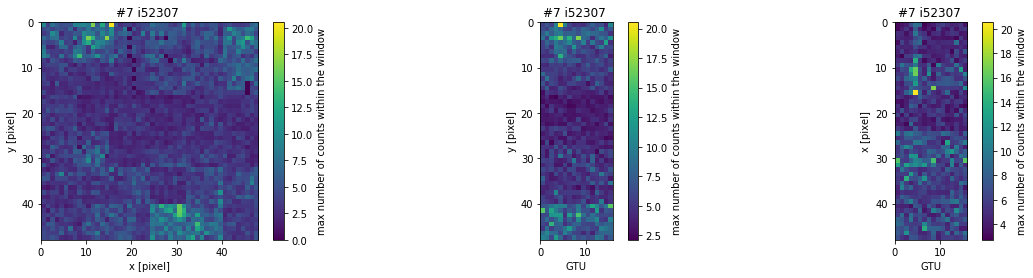

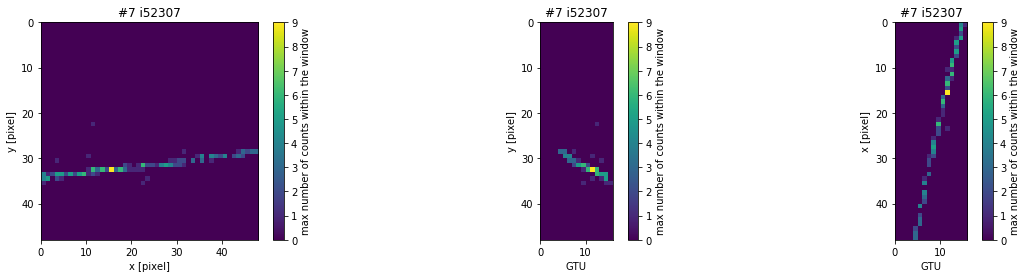

#8	(0)
	event_id: 49238
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 10
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-17h58m10s/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n650_m128_Cinverse_flat_average_directions_4m_flipud.npy
#8 id: 49238
!!!! simu_gtu_start=-4 simu_gtu_end=6


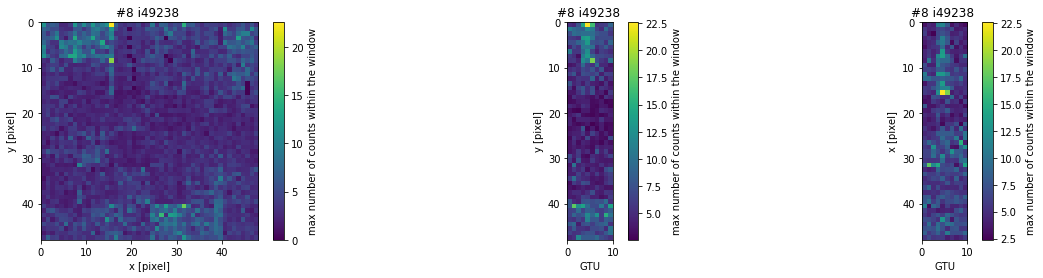

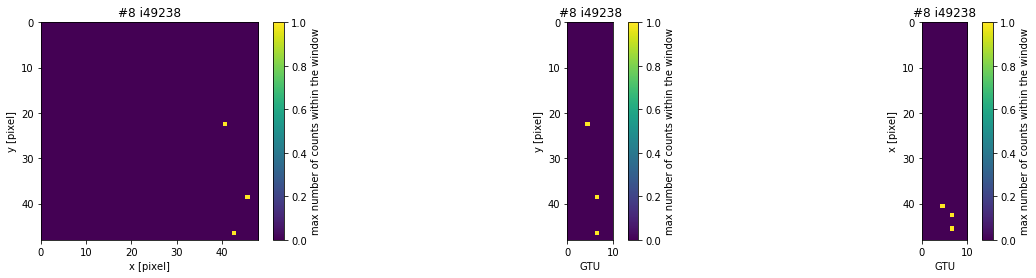

#9	(0)
	event_id: 48114
	packet_id: 1
	gtu_in_packet: 65
	num_gtu: 13
	source_file_acquisition: posz_27000000.00/energy_1.78e+12/thousnd27E5.2017-07-24-17h42m49s/npyconv/ev_65_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n609_m128_Cinverse_flat_average_directions_4m_flipud.npy
#9 id: 48114
!!!! simu_gtu_start=31 simu_gtu_end=44


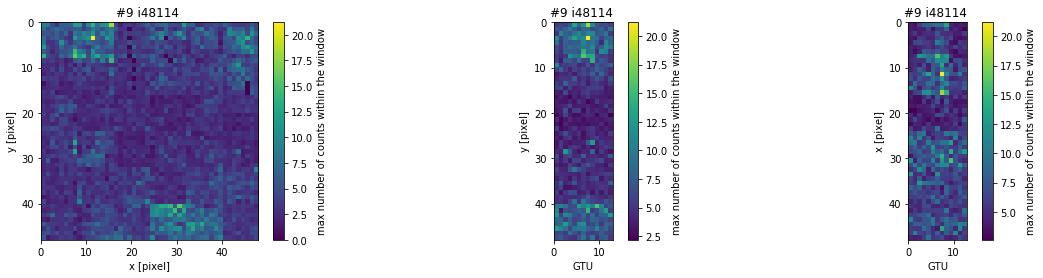

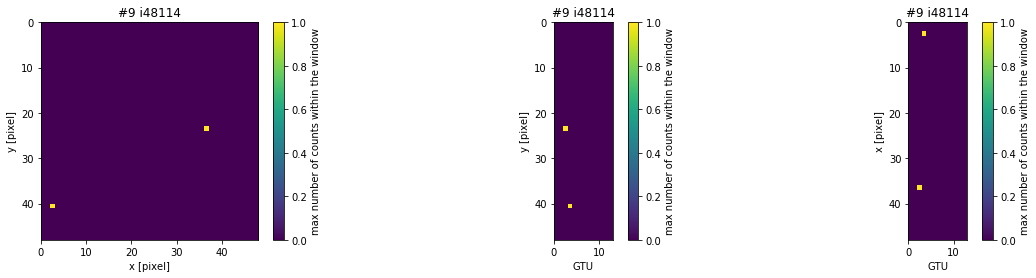

#0	(0)
	event_id: 2451105
	packet_id: 1
	gtu_in_packet: 43
	num_gtu: 17
	source_file_acquisition: posz_18000000.00/energy_2.40e+12/simu.2017-07-15-20h50m24s/npyconv/ev_9_mc_1__signals_p128_a0_g30_f128_b20170429-080135-025.001_k1_s0_d32_n39_m128_Cinverse_flat_average_directions_4m_flipud.npy
#0 id: 2451105
!!!! simu_gtu_start=9 simu_gtu_end=26


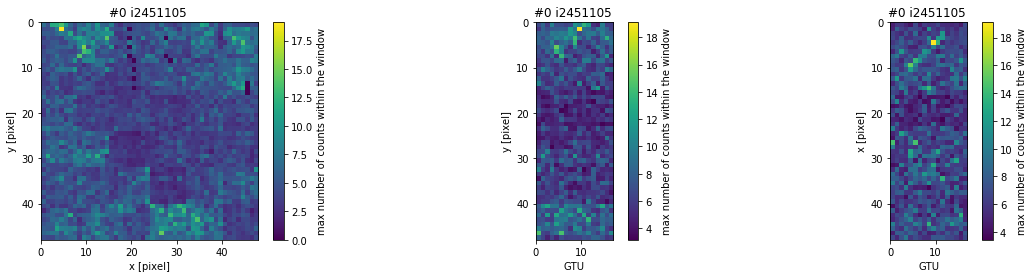

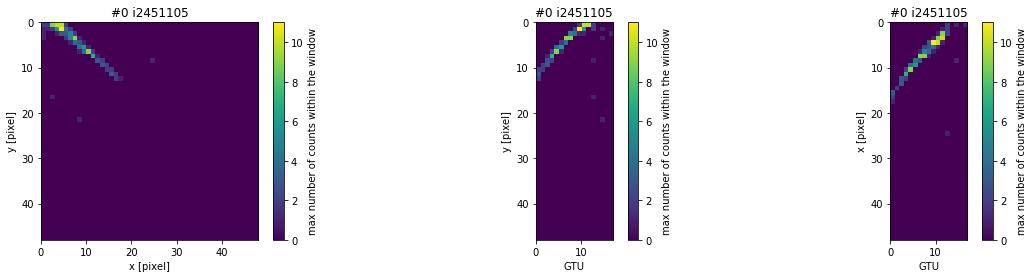

In [67]:
events_to_vis_df = simu_bgf1_tracks_nonan__insensitive__df.sort_values(['etruth_trueenergy'], ascending=[True])

single_proj_width=6 
single_proj_height=4
line_alpha=0.0


print('len(events_to_vis_df) =', len(events_to_vis_df))
print('-'*50)
    
for offset in \
        range(0, len(simu_bgf1_tracks_nonan__insensitive__df), len(simu_bgf1_tracks_nonan__insensitive__df)//4):
    vis_events_df(
        events_to_vis_df.iloc[offset:], 
        events_per_figure=10, max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=['source_file_acquisition'],
        line_columns_x_y=None, line_columns_gtu_x=None, line_columns_gtu_y=None,
        by_one=True,
        extension_func = lambda i, r, visualized_projections, fig, axs_flattened: \
            show_simu_event_row(i, r, print_offset=0, extra_columns=[], vis_xy=True, vis_gtux=True, vis_gtuy=True,
                                npy_pathname_column='simu2npy_signals_pathname', 
                                single_proj_width=single_proj_width, single_proj_height=single_proj_height,
                                print_info=True, warn_if_not_exact_simu=True),
        single_proj_width=single_proj_width, single_proj_height=single_proj_height,
        inverse_means_arr=inverse_means_map
    )
    print('='*50)

In [57]:
list(range(0, len(simu_bgf1_tracks_nonan__insensitive__df), len(simu_bgf1_tracks_nonan__insensitive__df)//3))

[0, 217, 434, 651]

#### By zenith angle (theta)

In [58]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_theta = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


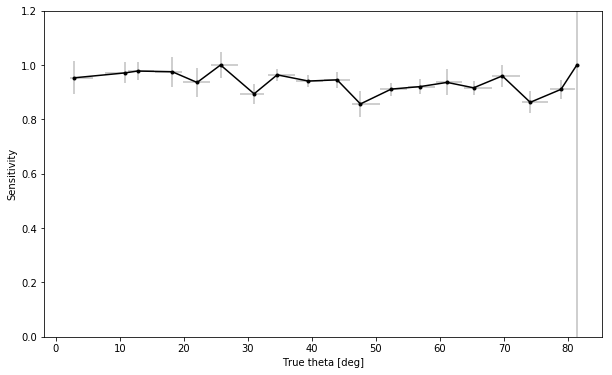

In [59]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

#### By azimuth angle (phi)

In [60]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_phi = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


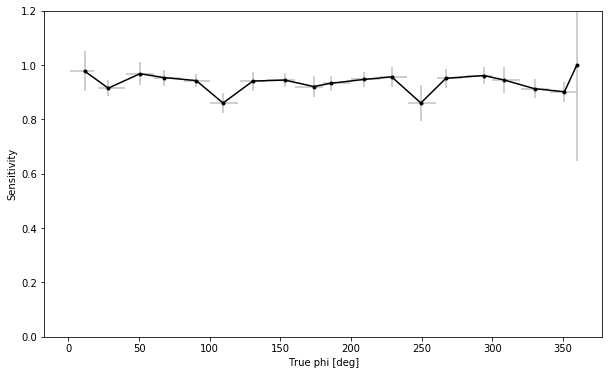

In [61]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True phi [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

### Sensitivity on L1 (bgf=1) triggered *unclassified* events

In [62]:
extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_unclassified_nonan_df['event_id'].values, 
        simu_bgf1_unclassified_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


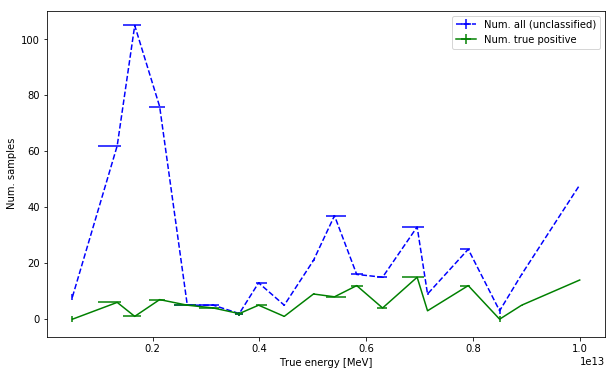

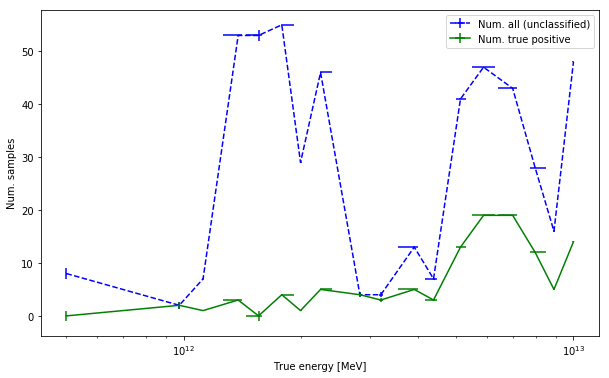

In [63]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. all (unclassified)', label='Num. all (unclassified)',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

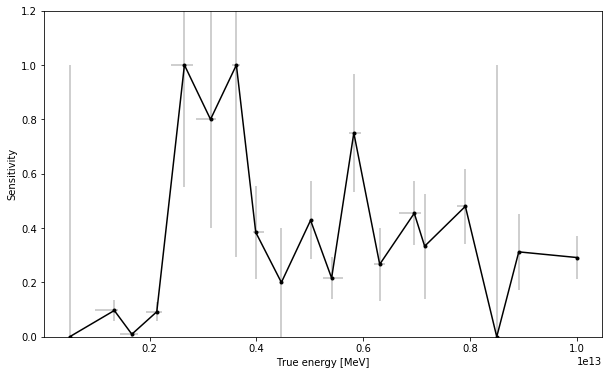

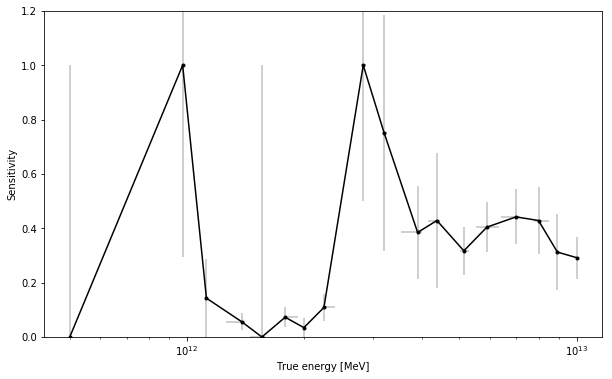

In [64]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

In [65]:
# backup for visualization

# extra_trees_classifier_y_pred_1_event_id = flight_nonan_event_id__values[extra_trees_classifier_on_train_kbest30__y_flight_pred == 1]
# events_to_vis_df = flight_df[flight_df['event_id'].isin(extra_trees_classifier_y_pred_1_event_id)].sort_values('rank', ascending=True)

# def print_classification(i, r, visualized_projections, fig, axs_flattened):
#     loc = np.argmax(flight_nonan_event_id__values == r['event_id'])
#     event_id_check = flight_nonan_event_id__values[loc]
#     extra_trees_classifier_y_pred = extra_trees_classifier_on_train_kbest30__y_flight_pred[loc]
    
#     print('\t----------------------------------')
#     print('\tevent_id_check =', event_id_check )
#     print('\textra_trees_classifier_y_pred =', extra_trees_classifier_y_pred )